In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, rewards, dones, rates

In [4]:
def Act(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Act', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [5]:
def Env(states, actions, state_size, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Env', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        states_logits = tf.layers.dense(inputs=nl2, units=state_size, trainable=False)
        Qlogits = tf.layers.dense(inputs=nl2, units=1, trainable=False)
        return states_logits, Qlogits

In [6]:
def model_loss(state_size, action_size, hidden_size, gamma,
               states, actions, next_states, dones, rates):
    ################################################ a = act(s)
    actions_logits = Act(states=states, hidden_size=hidden_size, action_size=action_size)
    ################################################ s', r = env(s, a)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    next_states_logits, Qlogits = Env(actions=actions_labels, states=states, hidden_size=hidden_size, 
                                      action_size=action_size, state_size=state_size)
    next_states_labels = tf.nn.sigmoid(next_states)
    eloss_ = tf.nn.sigmoid_cross_entropy_with_logits(logits=next_states_logits, labels=next_states_labels)
    eloss = tf.reduce_mean(tf.reduce_sum(eloss_, axis=1))
    #################################################### s'', Q' = ~env(s', ~a')
    next_actions_logits = Act(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    next_states_logits, nextQlogits = Env(actions=next_actions_logits, states=next_states, hidden_size=hidden_size, 
                                          action_size=action_size, state_size=state_size, reuse=True)
    #################################################### GAN
    Qlogits = tf.reshape(Qlogits, shape=[-1])
    nextQlogits = tf.reshape(nextQlogits, shape=[-1]) * (1-dones)
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qlogits, # GAN
                                                                    labels=rates)) # 0-1 real
    eloss += tf.reduce_mean(nextQlogits) # minimize nextQ
    aloss = -tf.reduce_mean(nextQlogits) # maximize nextQ
    ###################################################### Qlearning
    ###################################################### Q(s,a)= r + Q'(s',a')
    rewards = tf.reduce_mean(tf.square(Qlogits - (gamma * nextQlogits)))
    ##################################################### GAN + DDPG
    eloss += tf.reduce_mean(rewards) # minimize entropy=error
    aloss += -tf.reduce_mean(rewards) # maximize entropy=rewards
    return actions_logits, aloss, eloss, rewards

In [7]:
def model_opt(a_loss, e_loss, a_learning_rate, e_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('Act')]
    e_vars = [var for var in t_vars if var.name.startswith('Env')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        e_opt = tf.train.AdamOptimizer(e_learning_rate).minimize(e_loss, var_list=e_vars)
    return a_opt, e_opt

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, e_learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.e_loss, self.rewards_ = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, 
            dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.e_opt = model_opt(a_loss=self.a_loss, e_loss=self.e_loss,
                                           a_learning_rate=a_learning_rate,
                                           e_learning_rate=e_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
        return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
e_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size
gamma=0.99

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size, gamma=gamma,
              a_learning_rate=a_learning_rate, e_learning_rate=e_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        #print(done)
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        state = env.reset()
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [14]:
def minibacth(memory):
    # Training with the maxrated minibatch
    batch = memory.buffer
    #for idx in range(memory_size// batch_size):
    while True:
        idx = np.random.choice(np.arange(memory_size// batch_size))
        states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        states = states[rates >= np.max(rates)]
        actions = actions[rates >= np.max(rates)]
        next_states = next_states[rates >= np.max(rates)]
        rewards = rewards[rates >= np.max(rates)]
        dones = dones[rates >= np.max(rates)]
        rates = rates[rates >= np.max(rates)]
        if np.count_nonzero(dones) > 0 and len(dones) > 1 and np.max(rates) > 0:
            break
    return states, actions, next_states, rewards, dones, rates

In [15]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
aloss_list, eloss_list, aloss2_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes for running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        aloss_batch, eloss_batch, aloss2_batch = [], [], []
        total_reward = 0
        state = env.reset()
        rate = -1

        # Training steps/batches
        for num_step in range(11111):
            # Explore (env) or Exploit (model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            total_reward += reward
            state = next_state
            
            # Online policy/on-policy/online training
            states, actions, next_states, rewards, dones, rates = minibacth(memory=memory)
            feed_dict = {model.states: states, model.actions: actions, model.next_states: next_states,
                         model.rewards: rewards, model.dones: dones, model.rates: rates}
            eloss, _ = sess.run([model.e_loss, model.e_opt], feed_dict)
            aloss, _ = sess.run([model.a_loss, model.a_opt], feed_dict)
            eloss_batch.append(eloss)
            aloss_batch.append(aloss)
            # End of episode/result/success rate available
            if done is True:
                # Rating the latest played episode
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                        memory.buffer[-1-idx][-1] = rate # rate the trajectory/data
                break

        # Print out
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'eloss:{:.4f}'.format(np.mean(eloss_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        aloss_list.append([ep, np.mean(aloss_batch)])
        eloss_list.append([ep, np.mean(eloss_batch)])
        
        # Break episode/epoch loop
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of 500 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:17.0000 R:17.0000 rate:0.0340 aloss:-0.3665 eloss:4.1107 exploreP:0.9983
Episode:1 meanR:21.5000 R:26.0000 rate:0.0520 aloss:-0.2882 eloss:3.9948 exploreP:0.9958
Episode:2 meanR:19.3333 R:15.0000 rate:0.0300 aloss:-0.4877 eloss:4.2906 exploreP:0.9943
Episode:3 meanR:20.7500 R:25.0000 rate:0.0500 aloss:-0.2650 eloss:3.9523 exploreP:0.9918
Episode:4 meanR:20.2000 R:18.0000 rate:0.0360 aloss:-0.2235 eloss:3.8969 exploreP:0.9901
Episode:5 meanR:20.8333 R:24.0000 rate:0.0480 aloss:-0.2887 eloss:4.0132 exploreP:0.9877
Episode:6 meanR:20.5714 R:19.0000 rate:0.0380 aloss:-0.2152 eloss:3.8745 exploreP:0.9858
Episode:7 meanR:20.5000 R:20.0000 rate:0.0400 aloss:-0.1842 eloss:3.8401 exploreP:0.9839
Episode:8 meanR:23.8889 R:51.0000 rate:0.1020 aloss:-0.2077 eloss:3.8755 exploreP:0.9789
Episode:9 meanR:23.4000 R:19.0000 rate:0.0380 aloss:-0.1881 eloss:3.8501 exploreP:0.9771
Episode:10 meanR:24.2727 R:33.0000 rate:0.0660 aloss:-0.1627 eloss:3.7988 exploreP:0.9739
Episode:11 meanR:23.

Episode:92 meanR:20.6452 R:12.0000 rate:0.0240 aloss:0.8284 eloss:2.6117 exploreP:0.8271
Episode:93 meanR:20.8191 R:37.0000 rate:0.0740 aloss:0.8173 eloss:2.6251 exploreP:0.8240
Episode:94 meanR:20.7368 R:13.0000 rate:0.0260 aloss:0.8357 eloss:2.5810 exploreP:0.8230
Episode:95 meanR:20.6875 R:16.0000 rate:0.0320 aloss:0.8522 eloss:2.5574 exploreP:0.8217
Episode:96 meanR:20.6082 R:13.0000 rate:0.0260 aloss:0.8222 eloss:2.6608 exploreP:0.8206
Episode:97 meanR:20.6020 R:20.0000 rate:0.0400 aloss:0.8343 eloss:2.5980 exploreP:0.8190
Episode:98 meanR:20.6970 R:30.0000 rate:0.0600 aloss:0.8182 eloss:2.6448 exploreP:0.8166
Episode:99 meanR:20.6500 R:16.0000 rate:0.0320 aloss:0.8303 eloss:2.6050 exploreP:0.8153
Episode:100 meanR:20.6500 R:17.0000 rate:0.0340 aloss:0.8014 eloss:2.6812 exploreP:0.8139
Episode:101 meanR:20.5400 R:15.0000 rate:0.0300 aloss:0.8428 eloss:2.5687 exploreP:0.8127
Episode:102 meanR:20.5200 R:13.0000 rate:0.0260 aloss:0.8252 eloss:2.6390 exploreP:0.8117
Episode:103 meanR:

Episode:184 meanR:16.2400 R:13.0000 rate:0.0260 aloss:1.0450 eloss:2.3896 exploreP:0.7137
Episode:185 meanR:16.2900 R:18.0000 rate:0.0360 aloss:1.0556 eloss:2.3953 exploreP:0.7125
Episode:186 meanR:16.3600 R:17.0000 rate:0.0340 aloss:1.0732 eloss:2.3173 exploreP:0.7113
Episode:187 meanR:16.4000 R:16.0000 rate:0.0320 aloss:1.0680 eloss:2.3458 exploreP:0.7102
Episode:188 meanR:16.1000 R:14.0000 rate:0.0280 aloss:1.0838 eloss:2.2711 exploreP:0.7092
Episode:189 meanR:16.0500 R:11.0000 rate:0.0220 aloss:1.0998 eloss:2.3463 exploreP:0.7084
Episode:190 meanR:16.1400 R:20.0000 rate:0.0400 aloss:1.1044 eloss:2.3035 exploreP:0.7070
Episode:191 meanR:16.1200 R:11.0000 rate:0.0220 aloss:1.1143 eloss:2.2669 exploreP:0.7062
Episode:192 meanR:16.1600 R:16.0000 rate:0.0320 aloss:1.1079 eloss:2.2882 exploreP:0.7051
Episode:193 meanR:15.9200 R:13.0000 rate:0.0260 aloss:1.1376 eloss:2.2209 exploreP:0.7042
Episode:194 meanR:15.9800 R:19.0000 rate:0.0380 aloss:1.1419 eloss:2.2566 exploreP:0.7029
Episode:19

Episode:276 meanR:14.4000 R:17.0000 rate:0.0340 aloss:1.4700 eloss:1.8911 exploreP:0.6264
Episode:277 meanR:14.4400 R:17.0000 rate:0.0340 aloss:1.4845 eloss:1.9031 exploreP:0.6254
Episode:278 meanR:14.4000 R:10.0000 rate:0.0200 aloss:1.4781 eloss:1.8971 exploreP:0.6247
Episode:279 meanR:14.3200 R:10.0000 rate:0.0200 aloss:1.4890 eloss:1.9267 exploreP:0.6241
Episode:280 meanR:14.3300 R:20.0000 rate:0.0400 aloss:1.4880 eloss:1.8617 exploreP:0.6229
Episode:281 meanR:14.3300 R:13.0000 rate:0.0260 aloss:1.4430 eloss:1.9170 exploreP:0.6221
Episode:282 meanR:14.3700 R:18.0000 rate:0.0360 aloss:1.4915 eloss:1.9414 exploreP:0.6210
Episode:283 meanR:14.5500 R:29.0000 rate:0.0580 aloss:1.4848 eloss:1.9404 exploreP:0.6192
Episode:284 meanR:14.5800 R:16.0000 rate:0.0320 aloss:1.4428 eloss:1.9968 exploreP:0.6183
Episode:285 meanR:14.5500 R:15.0000 rate:0.0300 aloss:1.4847 eloss:1.9173 exploreP:0.6173
Episode:286 meanR:14.5000 R:12.0000 rate:0.0240 aloss:1.3810 eloss:1.9203 exploreP:0.6166
Episode:28

Episode:368 meanR:13.5600 R:9.0000 rate:0.0180 aloss:2.0017 eloss:1.4190 exploreP:0.5546
Episode:369 meanR:13.5800 R:14.0000 rate:0.0280 aloss:1.9655 eloss:1.4364 exploreP:0.5539
Episode:370 meanR:13.5400 R:10.0000 rate:0.0200 aloss:1.8257 eloss:1.6330 exploreP:0.5533
Episode:371 meanR:13.4800 R:9.0000 rate:0.0180 aloss:1.9817 eloss:1.5298 exploreP:0.5528
Episode:372 meanR:13.3300 R:10.0000 rate:0.0200 aloss:2.0117 eloss:1.4596 exploreP:0.5523
Episode:373 meanR:13.3700 R:16.0000 rate:0.0320 aloss:2.0193 eloss:1.4775 exploreP:0.5514
Episode:374 meanR:13.4600 R:21.0000 rate:0.0420 aloss:2.0186 eloss:1.5114 exploreP:0.5503
Episode:375 meanR:13.4700 R:12.0000 rate:0.0240 aloss:1.9829 eloss:1.4012 exploreP:0.5496
Episode:376 meanR:13.4800 R:18.0000 rate:0.0360 aloss:1.9735 eloss:1.5122 exploreP:0.5487
Episode:377 meanR:13.4300 R:12.0000 rate:0.0240 aloss:2.0219 eloss:1.4493 exploreP:0.5480
Episode:378 meanR:13.4400 R:11.0000 rate:0.0220 aloss:2.0139 eloss:1.4800 exploreP:0.5474
Episode:379 

Episode:460 meanR:12.7000 R:22.0000 rate:0.0440 aloss:2.2635 eloss:1.1782 exploreP:0.4948
Episode:461 meanR:12.7200 R:12.0000 rate:0.0240 aloss:2.3758 eloss:1.0897 exploreP:0.4943
Episode:462 meanR:12.6500 R:11.0000 rate:0.0220 aloss:2.3658 eloss:1.1629 exploreP:0.4937
Episode:463 meanR:12.6300 R:12.0000 rate:0.0240 aloss:2.3345 eloss:1.0537 exploreP:0.4931
Episode:464 meanR:12.6100 R:15.0000 rate:0.0300 aloss:2.3219 eloss:1.1180 exploreP:0.4924
Episode:465 meanR:12.6000 R:9.0000 rate:0.0180 aloss:2.3198 eloss:1.0465 exploreP:0.4920
Episode:466 meanR:12.6100 R:11.0000 rate:0.0220 aloss:2.3886 eloss:1.0535 exploreP:0.4915
Episode:467 meanR:12.5200 R:10.0000 rate:0.0200 aloss:2.4089 eloss:1.0850 exploreP:0.4910
Episode:468 meanR:12.5300 R:10.0000 rate:0.0200 aloss:2.3762 eloss:1.1260 exploreP:0.4905
Episode:469 meanR:12.5000 R:11.0000 rate:0.0220 aloss:2.3839 eloss:1.0682 exploreP:0.4900
Episode:470 meanR:12.5100 R:11.0000 rate:0.0220 aloss:2.3884 eloss:1.0778 exploreP:0.4894
Episode:471

Episode:552 meanR:11.8100 R:11.0000 rate:0.0220 aloss:2.7806 eloss:0.8129 exploreP:0.4459
Episode:553 meanR:11.7600 R:8.0000 rate:0.0160 aloss:2.7631 eloss:0.8498 exploreP:0.4455
Episode:554 meanR:11.8000 R:17.0000 rate:0.0340 aloss:2.8013 eloss:0.7805 exploreP:0.4448
Episode:555 meanR:11.7800 R:12.0000 rate:0.0240 aloss:2.8026 eloss:0.7954 exploreP:0.4443
Episode:556 meanR:11.7700 R:9.0000 rate:0.0180 aloss:2.8182 eloss:0.7667 exploreP:0.4439
Episode:557 meanR:11.7800 R:17.0000 rate:0.0340 aloss:2.8004 eloss:0.8054 exploreP:0.4432
Episode:558 meanR:11.8100 R:12.0000 rate:0.0240 aloss:2.7229 eloss:0.8128 exploreP:0.4426
Episode:559 meanR:11.7200 R:11.0000 rate:0.0220 aloss:2.1920 eloss:1.3725 exploreP:0.4422
Episode:560 meanR:11.5900 R:9.0000 rate:0.0180 aloss:2.8270 eloss:0.6984 exploreP:0.4418
Episode:561 meanR:11.5700 R:10.0000 rate:0.0200 aloss:2.8102 eloss:0.6594 exploreP:0.4413
Episode:562 meanR:11.5800 R:12.0000 rate:0.0240 aloss:2.8253 eloss:0.8308 exploreP:0.4408
Episode:563 m

Episode:644 meanR:11.5000 R:11.0000 rate:0.0220 aloss:3.1581 eloss:0.4419 exploreP:0.4017
Episode:645 meanR:11.5100 R:11.0000 rate:0.0220 aloss:2.7454 eloss:0.7744 exploreP:0.4012
Episode:646 meanR:11.5100 R:9.0000 rate:0.0180 aloss:2.7077 eloss:0.9316 exploreP:0.4009
Episode:647 meanR:11.5100 R:12.0000 rate:0.0240 aloss:3.2039 eloss:0.3966 exploreP:0.4004
Episode:648 meanR:11.5100 R:11.0000 rate:0.0220 aloss:3.1953 eloss:0.3575 exploreP:0.4000
Episode:649 meanR:11.5500 R:13.0000 rate:0.0260 aloss:3.2040 eloss:0.3928 exploreP:0.3995
Episode:650 meanR:11.6100 R:15.0000 rate:0.0300 aloss:3.1674 eloss:0.4041 exploreP:0.3989
Episode:651 meanR:11.6100 R:9.0000 rate:0.0180 aloss:3.1784 eloss:0.4554 exploreP:0.3985
Episode:652 meanR:11.6000 R:10.0000 rate:0.0200 aloss:3.1461 eloss:0.4316 exploreP:0.3982
Episode:653 meanR:11.6100 R:9.0000 rate:0.0180 aloss:3.2276 eloss:0.3853 exploreP:0.3978
Episode:654 meanR:11.5600 R:12.0000 rate:0.0240 aloss:3.2230 eloss:0.4732 exploreP:0.3973
Episode:655 m

Episode:736 meanR:11.2400 R:9.0000 rate:0.0180 aloss:3.5796 eloss:0.1503 exploreP:0.3631
Episode:737 meanR:11.2400 R:12.0000 rate:0.0240 aloss:3.4549 eloss:0.2675 exploreP:0.3627
Episode:738 meanR:11.2800 R:12.0000 rate:0.0240 aloss:3.6474 eloss:-0.0211 exploreP:0.3623
Episode:739 meanR:11.2800 R:13.0000 rate:0.0260 aloss:3.4713 eloss:0.2185 exploreP:0.3618
Episode:740 meanR:11.3200 R:14.0000 rate:0.0280 aloss:3.5049 eloss:0.1350 exploreP:0.3613
Episode:741 meanR:11.4200 R:18.0000 rate:0.0360 aloss:3.5399 eloss:0.1275 exploreP:0.3607
Episode:742 meanR:11.3900 R:10.0000 rate:0.0200 aloss:3.6407 eloss:0.0714 exploreP:0.3603
Episode:743 meanR:11.3600 R:10.0000 rate:0.0200 aloss:3.7080 eloss:0.0275 exploreP:0.3600
Episode:744 meanR:11.4200 R:17.0000 rate:0.0340 aloss:3.5765 eloss:0.0711 exploreP:0.3594
Episode:745 meanR:11.4100 R:10.0000 rate:0.0200 aloss:3.6341 eloss:0.0839 exploreP:0.3590
Episode:746 meanR:11.4000 R:8.0000 rate:0.0160 aloss:3.6171 eloss:0.1745 exploreP:0.3588
Episode:747

Episode:827 meanR:10.7000 R:9.0000 rate:0.0180 aloss:3.7680 eloss:-0.0916 exploreP:0.3301
Episode:828 meanR:10.7200 R:10.0000 rate:0.0200 aloss:3.9742 eloss:-0.2083 exploreP:0.3298
Episode:829 meanR:10.7200 R:12.0000 rate:0.0240 aloss:3.1584 eloss:0.6577 exploreP:0.3294
Episode:830 meanR:10.7300 R:9.0000 rate:0.0180 aloss:4.0398 eloss:-0.3323 exploreP:0.3291
Episode:831 meanR:10.7500 R:10.0000 rate:0.0200 aloss:3.9643 eloss:-0.2443 exploreP:0.3288
Episode:832 meanR:10.7700 R:11.0000 rate:0.0220 aloss:3.8007 eloss:-0.1116 exploreP:0.3284
Episode:833 meanR:10.7500 R:10.0000 rate:0.0200 aloss:4.1353 eloss:-0.2563 exploreP:0.3281
Episode:834 meanR:10.7600 R:12.0000 rate:0.0240 aloss:4.0387 eloss:-0.3145 exploreP:0.3277
Episode:835 meanR:10.7500 R:10.0000 rate:0.0200 aloss:4.0983 eloss:-0.2938 exploreP:0.3274
Episode:836 meanR:10.7700 R:11.0000 rate:0.0220 aloss:4.0091 eloss:-0.2985 exploreP:0.3271
Episode:837 meanR:10.7500 R:10.0000 rate:0.0200 aloss:3.6548 eloss:0.0028 exploreP:0.3267
Epi

Episode:918 meanR:10.8000 R:10.0000 rate:0.0200 aloss:4.3639 eloss:-0.5680 exploreP:0.3001
Episode:919 meanR:10.8000 R:13.0000 rate:0.0260 aloss:4.4410 eloss:-0.5634 exploreP:0.2997
Episode:920 meanR:10.8100 R:13.0000 rate:0.0260 aloss:4.2420 eloss:-0.4437 exploreP:0.2994
Episode:921 meanR:10.8500 R:14.0000 rate:0.0280 aloss:3.8975 eloss:-0.1484 exploreP:0.2990
Episode:922 meanR:10.8200 R:8.0000 rate:0.0160 aloss:4.2779 eloss:-0.5662 exploreP:0.2987
Episode:923 meanR:10.8100 R:9.0000 rate:0.0180 aloss:4.0585 eloss:-0.2259 exploreP:0.2985
Episode:924 meanR:10.8100 R:10.0000 rate:0.0200 aloss:4.3223 eloss:-0.3942 exploreP:0.2982
Episode:925 meanR:10.7900 R:10.0000 rate:0.0200 aloss:4.4833 eloss:-0.5887 exploreP:0.2979
Episode:926 meanR:10.8100 R:12.0000 rate:0.0240 aloss:4.3660 eloss:-0.5392 exploreP:0.2976
Episode:927 meanR:10.8300 R:11.0000 rate:0.0220 aloss:4.2523 eloss:-0.5378 exploreP:0.2972
Episode:928 meanR:10.8400 R:11.0000 rate:0.0220 aloss:4.3547 eloss:-0.5650 exploreP:0.2969
E

Episode:1009 meanR:11.1000 R:13.0000 rate:0.0260 aloss:4.6224 eloss:-0.6699 exploreP:0.2723
Episode:1010 meanR:11.1000 R:10.0000 rate:0.0200 aloss:4.8495 eloss:-0.7976 exploreP:0.2720
Episode:1011 meanR:11.0700 R:8.0000 rate:0.0160 aloss:4.8486 eloss:-0.9587 exploreP:0.2718
Episode:1012 meanR:11.0900 R:12.0000 rate:0.0240 aloss:4.8222 eloss:-0.8923 exploreP:0.2715
Episode:1013 meanR:11.0700 R:8.0000 rate:0.0160 aloss:4.6937 eloss:-0.8547 exploreP:0.2713
Episode:1014 meanR:11.0700 R:11.0000 rate:0.0220 aloss:4.8945 eloss:-0.9615 exploreP:0.2710
Episode:1015 meanR:11.0400 R:11.0000 rate:0.0220 aloss:4.7655 eloss:-0.8900 exploreP:0.2707
Episode:1016 meanR:11.0000 R:10.0000 rate:0.0200 aloss:4.7731 eloss:-0.8105 exploreP:0.2704
Episode:1017 meanR:10.9900 R:10.0000 rate:0.0200 aloss:4.8318 eloss:-1.0246 exploreP:0.2702
Episode:1018 meanR:11.0100 R:12.0000 rate:0.0240 aloss:4.9183 eloss:-1.0673 exploreP:0.2699
Episode:1019 meanR:10.9800 R:10.0000 rate:0.0200 aloss:4.9083 eloss:-1.0162 explor

Episode:1099 meanR:10.7200 R:10.0000 rate:0.0200 aloss:5.2857 eloss:-1.2563 exploreP:0.2484
Episode:1100 meanR:10.7200 R:10.0000 rate:0.0200 aloss:5.2995 eloss:-1.2383 exploreP:0.2482
Episode:1101 meanR:10.7300 R:9.0000 rate:0.0180 aloss:5.0326 eloss:-1.1305 exploreP:0.2479
Episode:1102 meanR:10.7000 R:9.0000 rate:0.0180 aloss:5.3216 eloss:-1.3092 exploreP:0.2477
Episode:1103 meanR:10.6900 R:11.0000 rate:0.0220 aloss:5.4045 eloss:-1.3892 exploreP:0.2475
Episode:1104 meanR:10.6800 R:9.0000 rate:0.0180 aloss:5.0276 eloss:-1.1429 exploreP:0.2472
Episode:1105 meanR:10.6500 R:10.0000 rate:0.0200 aloss:5.1388 eloss:-1.2173 exploreP:0.2470
Episode:1106 meanR:10.6700 R:13.0000 rate:0.0260 aloss:4.8697 eloss:-0.9891 exploreP:0.2467
Episode:1107 meanR:10.6200 R:11.0000 rate:0.0220 aloss:5.0271 eloss:-1.1246 exploreP:0.2464
Episode:1108 meanR:10.6000 R:10.0000 rate:0.0200 aloss:5.4070 eloss:-1.2975 exploreP:0.2462
Episode:1109 meanR:10.5700 R:10.0000 rate:0.0200 aloss:5.1617 eloss:-1.2691 explore

Episode:1189 meanR:10.5200 R:8.0000 rate:0.0160 aloss:5.2119 eloss:-1.2234 exploreP:0.2269
Episode:1190 meanR:10.5200 R:10.0000 rate:0.0200 aloss:5.4841 eloss:-1.5164 exploreP:0.2267
Episode:1191 meanR:10.5600 R:13.0000 rate:0.0260 aloss:5.7015 eloss:-1.6108 exploreP:0.2264
Episode:1192 meanR:10.5800 R:14.0000 rate:0.0280 aloss:5.6105 eloss:-1.5654 exploreP:0.2261
Episode:1193 meanR:10.5800 R:11.0000 rate:0.0220 aloss:5.6290 eloss:-1.6626 exploreP:0.2259
Episode:1194 meanR:10.5300 R:9.0000 rate:0.0180 aloss:5.2243 eloss:-1.2043 exploreP:0.2257
Episode:1195 meanR:10.5400 R:10.0000 rate:0.0200 aloss:5.5473 eloss:-1.6256 exploreP:0.2255
Episode:1196 meanR:10.6200 R:18.0000 rate:0.0360 aloss:4.7846 eloss:-0.8367 exploreP:0.2251
Episode:1197 meanR:10.5900 R:8.0000 rate:0.0160 aloss:5.5558 eloss:-1.6295 exploreP:0.2249
Episode:1198 meanR:10.5800 R:11.0000 rate:0.0220 aloss:5.4161 eloss:-1.5332 exploreP:0.2247
Episode:1199 meanR:10.5700 R:9.0000 rate:0.0180 aloss:5.5491 eloss:-1.5598 exploreP

Episode:1279 meanR:10.3800 R:13.0000 rate:0.0260 aloss:5.9235 eloss:-1.8648 exploreP:0.2074
Episode:1280 meanR:10.3900 R:10.0000 rate:0.0200 aloss:5.5904 eloss:-1.6322 exploreP:0.2072
Episode:1281 meanR:10.4300 R:13.0000 rate:0.0260 aloss:5.7777 eloss:-1.7184 exploreP:0.2070
Episode:1282 meanR:10.4600 R:12.0000 rate:0.0240 aloss:6.0251 eloss:-1.9610 exploreP:0.2067
Episode:1283 meanR:10.4700 R:11.0000 rate:0.0220 aloss:5.7352 eloss:-1.7129 exploreP:0.2065
Episode:1284 meanR:10.4600 R:11.0000 rate:0.0220 aloss:5.8326 eloss:-1.6919 exploreP:0.2063
Episode:1285 meanR:10.4600 R:10.0000 rate:0.0200 aloss:5.9397 eloss:-1.8481 exploreP:0.2061
Episode:1286 meanR:10.4500 R:9.0000 rate:0.0180 aloss:5.8793 eloss:-1.7158 exploreP:0.2059
Episode:1287 meanR:10.4600 R:10.0000 rate:0.0200 aloss:5.6484 eloss:-1.6223 exploreP:0.2057
Episode:1288 meanR:10.4700 R:11.0000 rate:0.0220 aloss:5.5669 eloss:-1.6197 exploreP:0.2055
Episode:1289 meanR:10.4800 R:9.0000 rate:0.0180 aloss:5.6862 eloss:-1.5920 explor

Episode:1369 meanR:10.3600 R:8.0000 rate:0.0160 aloss:6.4098 eloss:-2.2921 exploreP:0.1900
Episode:1370 meanR:10.3500 R:8.0000 rate:0.0160 aloss:6.2814 eloss:-2.1367 exploreP:0.1898
Episode:1371 meanR:10.3100 R:10.0000 rate:0.0200 aloss:5.9823 eloss:-1.9184 exploreP:0.1896
Episode:1372 meanR:10.2800 R:10.0000 rate:0.0200 aloss:6.3734 eloss:-2.3069 exploreP:0.1895
Episode:1373 meanR:10.2700 R:8.0000 rate:0.0160 aloss:5.1596 eloss:-1.1557 exploreP:0.1893
Episode:1374 meanR:10.2700 R:9.0000 rate:0.0180 aloss:6.2896 eloss:-2.0581 exploreP:0.1892
Episode:1375 meanR:10.2400 R:10.0000 rate:0.0200 aloss:6.6228 eloss:-2.3308 exploreP:0.1890
Episode:1376 meanR:10.2400 R:9.0000 rate:0.0180 aloss:6.4765 eloss:-2.3368 exploreP:0.1888
Episode:1377 meanR:10.2500 R:10.0000 rate:0.0200 aloss:5.6598 eloss:-1.7430 exploreP:0.1886
Episode:1378 meanR:10.2200 R:10.0000 rate:0.0200 aloss:6.1380 eloss:-2.0470 exploreP:0.1885
Episode:1379 meanR:10.1800 R:9.0000 rate:0.0180 aloss:6.4485 eloss:-2.3291 exploreP:0

Episode:1459 meanR:9.9100 R:12.0000 rate:0.0240 aloss:4.4502 eloss:-0.3573 exploreP:0.1746
Episode:1460 meanR:9.9100 R:9.0000 rate:0.0180 aloss:6.4791 eloss:-2.4594 exploreP:0.1745
Episode:1461 meanR:9.9100 R:11.0000 rate:0.0220 aloss:6.1555 eloss:-2.1040 exploreP:0.1743
Episode:1462 meanR:9.8900 R:9.0000 rate:0.0180 aloss:6.5531 eloss:-2.3878 exploreP:0.1741
Episode:1463 meanR:9.8700 R:8.0000 rate:0.0160 aloss:6.5479 eloss:-2.5880 exploreP:0.1740
Episode:1464 meanR:9.9000 R:12.0000 rate:0.0240 aloss:6.4216 eloss:-2.3205 exploreP:0.1738
Episode:1465 meanR:9.9000 R:9.0000 rate:0.0180 aloss:5.6844 eloss:-1.6789 exploreP:0.1737
Episode:1466 meanR:9.9000 R:11.0000 rate:0.0220 aloss:6.5697 eloss:-2.4049 exploreP:0.1735
Episode:1467 meanR:9.8900 R:9.0000 rate:0.0180 aloss:6.4175 eloss:-2.2845 exploreP:0.1733
Episode:1468 meanR:9.8800 R:10.0000 rate:0.0200 aloss:6.3435 eloss:-2.2435 exploreP:0.1732
Episode:1469 meanR:9.8900 R:9.0000 rate:0.0180 aloss:6.0058 eloss:-1.9291 exploreP:0.1730
Episo

Episode:1549 meanR:9.9600 R:10.0000 rate:0.0200 aloss:6.6324 eloss:-2.5408 exploreP:0.1605
Episode:1550 meanR:9.9800 R:10.0000 rate:0.0200 aloss:6.5420 eloss:-2.3791 exploreP:0.1603
Episode:1551 meanR:10.0000 R:10.0000 rate:0.0200 aloss:6.9480 eloss:-2.6500 exploreP:0.1602
Episode:1552 meanR:9.9900 R:9.0000 rate:0.0180 aloss:7.1109 eloss:-2.7876 exploreP:0.1600
Episode:1553 meanR:10.0000 R:9.0000 rate:0.0180 aloss:6.6124 eloss:-2.4918 exploreP:0.1599
Episode:1554 meanR:10.0200 R:12.0000 rate:0.0240 aloss:7.1152 eloss:-2.8496 exploreP:0.1597
Episode:1555 meanR:10.0400 R:11.0000 rate:0.0220 aloss:6.4925 eloss:-2.4954 exploreP:0.1595
Episode:1556 meanR:10.0400 R:9.0000 rate:0.0180 aloss:6.5290 eloss:-2.5415 exploreP:0.1594
Episode:1557 meanR:10.0300 R:9.0000 rate:0.0180 aloss:6.2822 eloss:-2.3077 exploreP:0.1593
Episode:1558 meanR:10.0000 R:10.0000 rate:0.0200 aloss:6.5296 eloss:-2.6447 exploreP:0.1591
Episode:1559 meanR:9.9700 R:9.0000 rate:0.0180 aloss:6.6353 eloss:-2.5149 exploreP:0.15

Episode:1640 meanR:9.7500 R:8.0000 rate:0.0160 aloss:7.0370 eloss:-2.9613 exploreP:0.1476
Episode:1641 meanR:9.7500 R:12.0000 rate:0.0240 aloss:7.1645 eloss:-2.9787 exploreP:0.1475
Episode:1642 meanR:9.7600 R:9.0000 rate:0.0180 aloss:6.7363 eloss:-2.6759 exploreP:0.1474
Episode:1643 meanR:9.7800 R:10.0000 rate:0.0200 aloss:6.7558 eloss:-2.6610 exploreP:0.1472
Episode:1644 meanR:9.8000 R:12.0000 rate:0.0240 aloss:7.3605 eloss:-3.0404 exploreP:0.1471
Episode:1645 meanR:9.8200 R:12.0000 rate:0.0240 aloss:7.0134 eloss:-2.8102 exploreP:0.1469
Episode:1646 meanR:9.8400 R:11.0000 rate:0.0220 aloss:6.9619 eloss:-2.8282 exploreP:0.1467
Episode:1647 meanR:9.8400 R:9.0000 rate:0.0180 aloss:6.8942 eloss:-2.7678 exploreP:0.1466
Episode:1648 meanR:9.8400 R:9.0000 rate:0.0180 aloss:6.6574 eloss:-2.7491 exploreP:0.1465
Episode:1649 meanR:9.8400 R:10.0000 rate:0.0200 aloss:6.4693 eloss:-2.4204 exploreP:0.1464
Episode:1650 meanR:9.8400 R:10.0000 rate:0.0200 aloss:7.6035 eloss:-3.2421 exploreP:0.1462
Epi

Episode:1731 meanR:10.1700 R:10.0000 rate:0.0200 aloss:6.8507 eloss:-2.7441 exploreP:0.1354
Episode:1732 meanR:10.1800 R:11.0000 rate:0.0220 aloss:7.2501 eloss:-3.1226 exploreP:0.1353
Episode:1733 meanR:10.2000 R:12.0000 rate:0.0240 aloss:7.7299 eloss:-3.5359 exploreP:0.1351
Episode:1734 meanR:10.2000 R:10.0000 rate:0.0200 aloss:7.6620 eloss:-3.4013 exploreP:0.1350
Episode:1735 meanR:10.1800 R:8.0000 rate:0.0160 aloss:6.6930 eloss:-2.4475 exploreP:0.1349
Episode:1736 meanR:10.1700 R:9.0000 rate:0.0180 aloss:4.4320 eloss:-0.3163 exploreP:0.1348
Episode:1737 meanR:10.1800 R:11.0000 rate:0.0220 aloss:7.4790 eloss:-3.1808 exploreP:0.1347
Episode:1738 meanR:10.1900 R:10.0000 rate:0.0200 aloss:7.5654 eloss:-3.3787 exploreP:0.1345
Episode:1739 meanR:10.2000 R:11.0000 rate:0.0220 aloss:7.4769 eloss:-3.1749 exploreP:0.1344
Episode:1740 meanR:10.2300 R:11.0000 rate:0.0220 aloss:6.6597 eloss:-2.4511 exploreP:0.1343
Episode:1741 meanR:10.2100 R:10.0000 rate:0.0200 aloss:7.1699 eloss:-3.0333 explor

Episode:1821 meanR:10.1100 R:10.0000 rate:0.0200 aloss:7.6638 eloss:-3.3293 exploreP:0.1245
Episode:1822 meanR:10.0800 R:8.0000 rate:0.0160 aloss:6.7991 eloss:-2.8529 exploreP:0.1244
Episode:1823 meanR:10.0700 R:9.0000 rate:0.0180 aloss:7.3651 eloss:-3.2265 exploreP:0.1243
Episode:1824 meanR:10.0700 R:9.0000 rate:0.0180 aloss:7.6120 eloss:-3.3466 exploreP:0.1242
Episode:1825 meanR:10.0900 R:12.0000 rate:0.0240 aloss:7.5296 eloss:-3.3522 exploreP:0.1241
Episode:1826 meanR:10.0700 R:8.0000 rate:0.0160 aloss:7.1091 eloss:-3.1678 exploreP:0.1240
Episode:1827 meanR:10.0900 R:12.0000 rate:0.0240 aloss:3.8727 eloss:0.2032 exploreP:0.1238
Episode:1828 meanR:10.1000 R:10.0000 rate:0.0200 aloss:7.0454 eloss:-2.9025 exploreP:0.1237
Episode:1829 meanR:10.0700 R:9.0000 rate:0.0180 aloss:8.1075 eloss:-3.6865 exploreP:0.1236
Episode:1830 meanR:10.0700 R:9.0000 rate:0.0180 aloss:7.7132 eloss:-3.4983 exploreP:0.1235
Episode:1831 meanR:10.0500 R:8.0000 rate:0.0160 aloss:6.8994 eloss:-2.7023 exploreP:0.1

Episode:1911 meanR:11.2500 R:11.0000 rate:0.0220 aloss:7.0754 eloss:-2.9161 exploreP:0.1134
Episode:1912 meanR:11.2600 R:13.0000 rate:0.0260 aloss:7.5693 eloss:-3.4449 exploreP:0.1133
Episode:1913 meanR:11.2800 R:12.0000 rate:0.0240 aloss:8.1436 eloss:-3.8464 exploreP:0.1131
Episode:1914 meanR:11.2700 R:9.0000 rate:0.0180 aloss:6.8632 eloss:-2.7767 exploreP:0.1130
Episode:1915 meanR:11.2200 R:11.0000 rate:0.0220 aloss:8.1452 eloss:-3.8976 exploreP:0.1129
Episode:1916 meanR:11.2800 R:17.0000 rate:0.0340 aloss:7.7894 eloss:-3.6395 exploreP:0.1128
Episode:1917 meanR:11.2800 R:9.0000 rate:0.0180 aloss:8.6003 eloss:-4.0165 exploreP:0.1127
Episode:1918 meanR:11.3000 R:11.0000 rate:0.0220 aloss:7.4773 eloss:-3.3551 exploreP:0.1126
Episode:1919 meanR:11.3500 R:13.0000 rate:0.0260 aloss:7.6332 eloss:-3.5900 exploreP:0.1124
Episode:1920 meanR:11.3700 R:12.0000 rate:0.0240 aloss:7.0821 eloss:-3.0469 exploreP:0.1123
Episode:1921 meanR:11.3800 R:11.0000 rate:0.0220 aloss:1.6021 eloss:2.7225 explore

Episode:2001 meanR:12.9200 R:13.0000 rate:0.0260 aloss:7.2612 eloss:-3.0768 exploreP:0.1021
Episode:2002 meanR:12.8600 R:12.0000 rate:0.0240 aloss:7.6837 eloss:-3.5022 exploreP:0.1019
Episode:2003 meanR:12.8500 R:13.0000 rate:0.0260 aloss:7.5244 eloss:-3.4352 exploreP:0.1018
Episode:2004 meanR:12.8600 R:12.0000 rate:0.0240 aloss:7.8605 eloss:-3.5402 exploreP:0.1017
Episode:2005 meanR:12.8300 R:10.0000 rate:0.0200 aloss:8.6128 eloss:-4.2146 exploreP:0.1016
Episode:2006 meanR:12.8500 R:12.0000 rate:0.0240 aloss:8.0158 eloss:-3.7028 exploreP:0.1015
Episode:2007 meanR:12.8100 R:11.0000 rate:0.0220 aloss:7.4433 eloss:-3.3997 exploreP:0.1014
Episode:2008 meanR:12.8300 R:15.0000 rate:0.0300 aloss:8.0873 eloss:-3.6525 exploreP:0.1013
Episode:2009 meanR:12.8000 R:11.0000 rate:0.0220 aloss:5.2815 eloss:-0.8390 exploreP:0.1012
Episode:2010 meanR:12.8300 R:14.0000 rate:0.0280 aloss:6.5499 eloss:-2.3349 exploreP:0.1010
Episode:2011 meanR:12.8500 R:13.0000 rate:0.0260 aloss:8.3743 eloss:-4.1541 expl

Episode:2091 meanR:17.4100 R:18.0000 rate:0.0360 aloss:7.8470 eloss:-3.5867 exploreP:0.0883
Episode:2092 meanR:17.4400 R:16.0000 rate:0.0320 aloss:8.6324 eloss:-4.3215 exploreP:0.0882
Episode:2093 meanR:17.4600 R:16.0000 rate:0.0320 aloss:8.2406 eloss:-4.0320 exploreP:0.0881
Episode:2094 meanR:17.4800 R:14.0000 rate:0.0280 aloss:8.9164 eloss:-4.3648 exploreP:0.0880
Episode:2095 meanR:17.5200 R:14.0000 rate:0.0280 aloss:8.4164 eloss:-4.0695 exploreP:0.0879
Episode:2096 meanR:17.5500 R:17.0000 rate:0.0340 aloss:8.9218 eloss:-4.4188 exploreP:0.0877
Episode:2097 meanR:17.6000 R:16.0000 rate:0.0320 aloss:7.4788 eloss:-3.4242 exploreP:0.0876
Episode:2098 meanR:17.5800 R:11.0000 rate:0.0220 aloss:9.0930 eloss:-4.6124 exploreP:0.0875
Episode:2099 meanR:17.6500 R:20.0000 rate:0.0400 aloss:7.3265 eloss:-2.9502 exploreP:0.0874
Episode:2100 meanR:17.6500 R:12.0000 rate:0.0240 aloss:9.0039 eloss:-4.5983 exploreP:0.0873
Episode:2101 meanR:17.6600 R:14.0000 rate:0.0280 aloss:8.8280 eloss:-4.4579 expl

Episode:2181 meanR:19.2400 R:17.0000 rate:0.0340 aloss:8.7146 eloss:-4.3610 exploreP:0.0760
Episode:2182 meanR:19.1100 R:15.0000 rate:0.0300 aloss:6.9056 eloss:-2.7958 exploreP:0.0759
Episode:2183 meanR:19.0000 R:13.0000 rate:0.0260 aloss:8.6869 eloss:-4.3714 exploreP:0.0758
Episode:2184 meanR:18.9800 R:12.0000 rate:0.0240 aloss:9.0543 eloss:-4.5648 exploreP:0.0757
Episode:2185 meanR:18.9600 R:17.0000 rate:0.0340 aloss:8.4742 eloss:-4.0959 exploreP:0.0756
Episode:2186 meanR:18.9100 R:14.0000 rate:0.0280 aloss:8.2736 eloss:-3.9830 exploreP:0.0755
Episode:2187 meanR:18.8600 R:13.0000 rate:0.0260 aloss:8.2602 eloss:-3.9738 exploreP:0.0754
Episode:2188 meanR:18.7100 R:14.0000 rate:0.0280 aloss:7.2825 eloss:-3.0580 exploreP:0.0753
Episode:2189 meanR:18.6000 R:12.0000 rate:0.0240 aloss:8.6080 eloss:-4.4307 exploreP:0.0753
Episode:2190 meanR:18.5100 R:10.0000 rate:0.0200 aloss:9.4008 eloss:-4.9071 exploreP:0.0752
Episode:2191 meanR:18.4400 R:11.0000 rate:0.0220 aloss:8.3431 eloss:-4.3668 expl

Episode:2271 meanR:15.9300 R:10.0000 rate:0.0200 aloss:9.3800 eloss:-4.8912 exploreP:0.0679
Episode:2272 meanR:15.4900 R:9.0000 rate:0.0180 aloss:8.5455 eloss:-4.3114 exploreP:0.0678
Episode:2273 meanR:15.1800 R:9.0000 rate:0.0180 aloss:9.8116 eloss:-5.3107 exploreP:0.0677
Episode:2274 meanR:14.9800 R:9.0000 rate:0.0180 aloss:9.1433 eloss:-4.6853 exploreP:0.0677
Episode:2275 meanR:14.7900 R:9.0000 rate:0.0180 aloss:8.9350 eloss:-4.5967 exploreP:0.0676
Episode:2276 meanR:14.5700 R:9.0000 rate:0.0180 aloss:9.0180 eloss:-4.5886 exploreP:0.0676
Episode:2277 meanR:14.3800 R:9.0000 rate:0.0180 aloss:9.3875 eloss:-5.0566 exploreP:0.0675
Episode:2278 meanR:14.3200 R:10.0000 rate:0.0200 aloss:9.8573 eloss:-5.1773 exploreP:0.0675
Episode:2279 meanR:14.1900 R:9.0000 rate:0.0180 aloss:9.5579 eloss:-5.1772 exploreP:0.0674
Episode:2280 meanR:14.1600 R:10.0000 rate:0.0200 aloss:8.4881 eloss:-4.3652 exploreP:0.0674
Episode:2281 meanR:14.0800 R:9.0000 rate:0.0180 aloss:7.7610 eloss:-3.4552 exploreP:0.0

Episode:2361 meanR:12.6100 R:10.0000 rate:0.0200 aloss:10.0032 eloss:-5.4154 exploreP:0.0615
Episode:2362 meanR:12.5900 R:8.0000 rate:0.0160 aloss:8.0821 eloss:-3.8317 exploreP:0.0615
Episode:2363 meanR:12.6000 R:11.0000 rate:0.0220 aloss:9.3160 eloss:-4.8237 exploreP:0.0614
Episode:2364 meanR:12.6200 R:12.0000 rate:0.0240 aloss:8.2123 eloss:-4.0162 exploreP:0.0614
Episode:2365 meanR:12.6400 R:10.0000 rate:0.0200 aloss:10.3503 eloss:-5.6184 exploreP:0.0613
Episode:2366 meanR:12.6400 R:9.0000 rate:0.0180 aloss:8.1280 eloss:-3.6892 exploreP:0.0613
Episode:2367 meanR:12.6700 R:12.0000 rate:0.0240 aloss:9.6338 eloss:-5.1049 exploreP:0.0612
Episode:2368 meanR:12.6400 R:9.0000 rate:0.0180 aloss:9.9358 eloss:-5.3582 exploreP:0.0612
Episode:2369 meanR:12.6300 R:10.0000 rate:0.0200 aloss:9.2381 eloss:-4.7380 exploreP:0.0611
Episode:2370 meanR:12.6100 R:10.0000 rate:0.0200 aloss:7.0296 eloss:-2.5615 exploreP:0.0610
Episode:2371 meanR:12.6400 R:13.0000 rate:0.0260 aloss:9.0663 eloss:-4.6562 explo

Episode:2451 meanR:9.8000 R:10.0000 rate:0.0200 aloss:9.2825 eloss:-4.8000 exploreP:0.0572
Episode:2452 meanR:9.8100 R:9.0000 rate:0.0180 aloss:9.7384 eloss:-5.5133 exploreP:0.0571
Episode:2453 meanR:9.8000 R:9.0000 rate:0.0180 aloss:9.7225 eloss:-5.2396 exploreP:0.0571
Episode:2454 meanR:9.8000 R:9.0000 rate:0.0180 aloss:9.6193 eloss:-5.1643 exploreP:0.0570
Episode:2455 meanR:9.8000 R:10.0000 rate:0.0200 aloss:9.7641 eloss:-5.3761 exploreP:0.0570
Episode:2456 meanR:9.7900 R:9.0000 rate:0.0180 aloss:10.0845 eloss:-5.7706 exploreP:0.0570
Episode:2457 meanR:9.7700 R:8.0000 rate:0.0160 aloss:9.2997 eloss:-4.8694 exploreP:0.0569
Episode:2458 meanR:9.7600 R:9.0000 rate:0.0180 aloss:9.7684 eloss:-5.2560 exploreP:0.0569
Episode:2459 meanR:9.7500 R:9.0000 rate:0.0180 aloss:8.4187 eloss:-4.2917 exploreP:0.0568
Episode:2460 meanR:9.7200 R:10.0000 rate:0.0200 aloss:10.2231 eloss:-5.8462 exploreP:0.0568
Episode:2461 meanR:9.7200 R:10.0000 rate:0.0200 aloss:8.3980 eloss:-4.1707 exploreP:0.0567
Epis

Episode:2542 meanR:9.6600 R:11.0000 rate:0.0220 aloss:7.4328 eloss:-2.8934 exploreP:0.0532
Episode:2543 meanR:9.6400 R:9.0000 rate:0.0180 aloss:7.9867 eloss:-3.6140 exploreP:0.0532
Episode:2544 meanR:9.6500 R:10.0000 rate:0.0200 aloss:10.0291 eloss:-5.5603 exploreP:0.0531
Episode:2545 meanR:9.6500 R:10.0000 rate:0.0200 aloss:8.5797 eloss:-4.1390 exploreP:0.0531
Episode:2546 meanR:9.6300 R:9.0000 rate:0.0180 aloss:10.3655 eloss:-5.8054 exploreP:0.0531
Episode:2547 meanR:9.6400 R:10.0000 rate:0.0200 aloss:10.3247 eloss:-5.6746 exploreP:0.0530
Episode:2548 meanR:9.6400 R:10.0000 rate:0.0200 aloss:9.9546 eloss:-5.3745 exploreP:0.0530
Episode:2549 meanR:9.6300 R:9.0000 rate:0.0180 aloss:9.4667 eloss:-5.2185 exploreP:0.0529
Episode:2550 meanR:9.6200 R:10.0000 rate:0.0200 aloss:9.7646 eloss:-5.3255 exploreP:0.0529
Episode:2551 meanR:9.6200 R:10.0000 rate:0.0200 aloss:9.8810 eloss:-5.5868 exploreP:0.0528
Episode:2552 meanR:9.6100 R:8.0000 rate:0.0160 aloss:8.9036 eloss:-4.8888 exploreP:0.0528


Episode:2633 meanR:9.4000 R:10.0000 rate:0.0200 aloss:8.0257 eloss:-3.8168 exploreP:0.0497
Episode:2634 meanR:9.3900 R:9.0000 rate:0.0180 aloss:9.8539 eloss:-5.2555 exploreP:0.0497
Episode:2635 meanR:9.4100 R:11.0000 rate:0.0220 aloss:10.3029 eloss:-5.6813 exploreP:0.0496
Episode:2636 meanR:9.4100 R:9.0000 rate:0.0180 aloss:9.1623 eloss:-4.7279 exploreP:0.0496
Episode:2637 meanR:9.4000 R:9.0000 rate:0.0180 aloss:7.4934 eloss:-3.4014 exploreP:0.0495
Episode:2638 meanR:9.4000 R:9.0000 rate:0.0180 aloss:8.4252 eloss:-4.0989 exploreP:0.0495
Episode:2639 meanR:9.4000 R:10.0000 rate:0.0200 aloss:9.9032 eloss:-5.4253 exploreP:0.0495
Episode:2640 meanR:9.4000 R:10.0000 rate:0.0200 aloss:7.4126 eloss:-3.2578 exploreP:0.0494
Episode:2641 meanR:9.4100 R:9.0000 rate:0.0180 aloss:9.4330 eloss:-5.2462 exploreP:0.0494
Episode:2642 meanR:9.3900 R:9.0000 rate:0.0180 aloss:8.6904 eloss:-4.5520 exploreP:0.0494
Episode:2643 meanR:9.3800 R:8.0000 rate:0.0160 aloss:8.8121 eloss:-4.5209 exploreP:0.0493
Episo

Episode:2724 meanR:9.4600 R:9.0000 rate:0.0180 aloss:9.3317 eloss:-4.8447 exploreP:0.0464
Episode:2725 meanR:9.4700 R:10.0000 rate:0.0200 aloss:8.2516 eloss:-4.0872 exploreP:0.0464
Episode:2726 meanR:9.4800 R:9.0000 rate:0.0180 aloss:1.6753 eloss:2.6943 exploreP:0.0463
Episode:2727 meanR:9.4700 R:8.0000 rate:0.0160 aloss:10.6765 eloss:-6.0170 exploreP:0.0463
Episode:2728 meanR:9.4700 R:11.0000 rate:0.0220 aloss:9.6819 eloss:-5.1449 exploreP:0.0463
Episode:2729 meanR:9.4800 R:9.0000 rate:0.0180 aloss:8.4226 eloss:-4.1581 exploreP:0.0462
Episode:2730 meanR:9.4600 R:8.0000 rate:0.0160 aloss:9.0574 eloss:-4.9458 exploreP:0.0462
Episode:2731 meanR:9.4700 R:10.0000 rate:0.0200 aloss:8.4390 eloss:-3.8338 exploreP:0.0462
Episode:2732 meanR:9.4600 R:9.0000 rate:0.0180 aloss:9.3839 eloss:-5.1194 exploreP:0.0461
Episode:2733 meanR:9.4400 R:8.0000 rate:0.0160 aloss:2.9711 eloss:1.6099 exploreP:0.0461
Episode:2734 meanR:9.4500 R:10.0000 rate:0.0200 aloss:8.5973 eloss:-4.5538 exploreP:0.0461
Episode

Episode:2815 meanR:9.4400 R:10.0000 rate:0.0200 aloss:9.5698 eloss:-5.3843 exploreP:0.0434
Episode:2816 meanR:9.4500 R:10.0000 rate:0.0200 aloss:6.3170 eloss:-2.1218 exploreP:0.0434
Episode:2817 meanR:9.4700 R:11.0000 rate:0.0220 aloss:6.8650 eloss:-2.9890 exploreP:0.0433
Episode:2818 meanR:9.4600 R:9.0000 rate:0.0180 aloss:8.1554 eloss:-4.1347 exploreP:0.0433
Episode:2819 meanR:9.4600 R:10.0000 rate:0.0200 aloss:7.4672 eloss:-3.3119 exploreP:0.0433
Episode:2820 meanR:9.4600 R:10.0000 rate:0.0200 aloss:10.4031 eloss:-6.0547 exploreP:0.0432
Episode:2821 meanR:9.4700 R:9.0000 rate:0.0180 aloss:9.8917 eloss:-5.3491 exploreP:0.0432
Episode:2822 meanR:9.4700 R:9.0000 rate:0.0180 aloss:10.0152 eloss:-5.6682 exploreP:0.0432
Episode:2823 meanR:9.4700 R:9.0000 rate:0.0180 aloss:9.2816 eloss:-4.6830 exploreP:0.0431
Episode:2824 meanR:9.4800 R:10.0000 rate:0.0200 aloss:9.7304 eloss:-5.5955 exploreP:0.0431
Episode:2825 meanR:9.4800 R:10.0000 rate:0.0200 aloss:5.1270 eloss:-0.8849 exploreP:0.0431
E

Episode:2906 meanR:9.5400 R:8.0000 rate:0.0160 aloss:7.2024 eloss:-2.9593 exploreP:0.0406
Episode:2907 meanR:9.5400 R:10.0000 rate:0.0200 aloss:9.0598 eloss:-4.7801 exploreP:0.0406
Episode:2908 meanR:9.5500 R:9.0000 rate:0.0180 aloss:10.9883 eloss:-6.5607 exploreP:0.0406
Episode:2909 meanR:9.5500 R:9.0000 rate:0.0180 aloss:11.1669 eloss:-6.2855 exploreP:0.0405
Episode:2910 meanR:9.5400 R:9.0000 rate:0.0180 aloss:8.2012 eloss:-3.7687 exploreP:0.0405
Episode:2911 meanR:9.5500 R:9.0000 rate:0.0180 aloss:6.8755 eloss:-3.1037 exploreP:0.0405
Episode:2912 meanR:9.5600 R:10.0000 rate:0.0200 aloss:11.0604 eloss:-6.3174 exploreP:0.0404
Episode:2913 meanR:9.5700 R:10.0000 rate:0.0200 aloss:9.0493 eloss:-4.6954 exploreP:0.0404
Episode:2914 meanR:9.5700 R:10.0000 rate:0.0200 aloss:7.5982 eloss:-3.3256 exploreP:0.0404
Episode:2915 meanR:9.5600 R:9.0000 rate:0.0180 aloss:6.9993 eloss:-2.8939 exploreP:0.0404
Episode:2916 meanR:9.5600 R:10.0000 rate:0.0200 aloss:7.6689 eloss:-3.3534 exploreP:0.0403
Ep

Episode:2997 meanR:9.4800 R:10.0000 rate:0.0200 aloss:8.4918 eloss:-4.4181 exploreP:0.0381
Episode:2998 meanR:9.4700 R:8.0000 rate:0.0160 aloss:10.3166 eloss:-5.8249 exploreP:0.0381
Episode:2999 meanR:9.4700 R:10.0000 rate:0.0200 aloss:9.2588 eloss:-5.0081 exploreP:0.0380
Episode:3000 meanR:9.4600 R:10.0000 rate:0.0200 aloss:8.2938 eloss:-4.1810 exploreP:0.0380
Episode:3001 meanR:9.4700 R:10.0000 rate:0.0200 aloss:10.0246 eloss:-5.2182 exploreP:0.0380
Episode:3002 meanR:9.4800 R:9.0000 rate:0.0180 aloss:6.1724 eloss:-1.9735 exploreP:0.0380
Episode:3003 meanR:9.4800 R:10.0000 rate:0.0200 aloss:9.5123 eloss:-5.4588 exploreP:0.0379
Episode:3004 meanR:9.4700 R:9.0000 rate:0.0180 aloss:9.3481 eloss:-5.0508 exploreP:0.0379
Episode:3005 meanR:9.4700 R:9.0000 rate:0.0180 aloss:10.9051 eloss:-6.4221 exploreP:0.0379
Episode:3006 meanR:9.4700 R:8.0000 rate:0.0160 aloss:9.3950 eloss:-5.1686 exploreP:0.0379
Episode:3007 meanR:9.4500 R:8.0000 rate:0.0160 aloss:10.3009 eloss:-5.9356 exploreP:0.0378
E

Episode:3088 meanR:9.4400 R:9.0000 rate:0.0180 aloss:8.4876 eloss:-4.5406 exploreP:0.0358
Episode:3089 meanR:9.4400 R:8.0000 rate:0.0160 aloss:8.4436 eloss:-4.1352 exploreP:0.0357
Episode:3090 meanR:9.4800 R:12.0000 rate:0.0240 aloss:11.3160 eloss:-6.5313 exploreP:0.0357
Episode:3091 meanR:9.4700 R:9.0000 rate:0.0180 aloss:7.2173 eloss:-3.0246 exploreP:0.0357
Episode:3092 meanR:9.5000 R:11.0000 rate:0.0220 aloss:9.5809 eloss:-5.4368 exploreP:0.0357
Episode:3093 meanR:9.5300 R:12.0000 rate:0.0240 aloss:9.2859 eloss:-4.8781 exploreP:0.0356
Episode:3094 meanR:9.5200 R:9.0000 rate:0.0180 aloss:8.9105 eloss:-4.8656 exploreP:0.0356
Episode:3095 meanR:9.5000 R:8.0000 rate:0.0160 aloss:10.7828 eloss:-6.1331 exploreP:0.0356
Episode:3096 meanR:9.5200 R:10.0000 rate:0.0200 aloss:9.5409 eloss:-5.3012 exploreP:0.0356
Episode:3097 meanR:9.5100 R:9.0000 rate:0.0180 aloss:10.2489 eloss:-5.4125 exploreP:0.0355
Episode:3098 meanR:9.5200 R:9.0000 rate:0.0180 aloss:9.0185 eloss:-4.9161 exploreP:0.0355
Epi

Episode:3179 meanR:9.2800 R:9.0000 rate:0.0180 aloss:9.3571 eloss:-4.9929 exploreP:0.0337
Episode:3180 meanR:9.2900 R:9.0000 rate:0.0180 aloss:4.8319 eloss:-0.8719 exploreP:0.0337
Episode:3181 meanR:9.2900 R:10.0000 rate:0.0200 aloss:10.6703 eloss:-6.2639 exploreP:0.0336
Episode:3182 meanR:9.2900 R:9.0000 rate:0.0180 aloss:8.3739 eloss:-4.5140 exploreP:0.0336
Episode:3183 meanR:9.3100 R:10.0000 rate:0.0200 aloss:5.3572 eloss:-1.0010 exploreP:0.0336
Episode:3184 meanR:9.3000 R:9.0000 rate:0.0180 aloss:8.9939 eloss:-4.8779 exploreP:0.0336
Episode:3185 meanR:9.3100 R:10.0000 rate:0.0200 aloss:0.4118 eloss:3.5672 exploreP:0.0335
Episode:3186 meanR:9.3000 R:9.0000 rate:0.0180 aloss:10.0195 eloss:-5.6052 exploreP:0.0335
Episode:3187 meanR:9.3000 R:9.0000 rate:0.0180 aloss:8.1869 eloss:-3.9049 exploreP:0.0335
Episode:3188 meanR:9.3000 R:9.0000 rate:0.0180 aloss:10.1915 eloss:-5.7513 exploreP:0.0335
Episode:3189 meanR:9.3300 R:11.0000 rate:0.0220 aloss:8.4647 eloss:-4.3566 exploreP:0.0334
Epis

Episode:3269 meanR:10.8200 R:11.0000 rate:0.0220 aloss:9.3205 eloss:-4.9579 exploreP:0.0314
Episode:3270 meanR:10.8300 R:11.0000 rate:0.0220 aloss:10.4344 eloss:-5.9549 exploreP:0.0314
Episode:3271 meanR:10.9000 R:18.0000 rate:0.0360 aloss:8.8314 eloss:-4.5109 exploreP:0.0314
Episode:3272 meanR:10.9200 R:10.0000 rate:0.0200 aloss:7.3560 eloss:-2.8875 exploreP:0.0314
Episode:3273 meanR:10.9400 R:12.0000 rate:0.0240 aloss:11.1362 eloss:-6.4830 exploreP:0.0313
Episode:3274 meanR:10.9400 R:9.0000 rate:0.0180 aloss:7.2756 eloss:-2.9380 exploreP:0.0313
Episode:3275 meanR:10.9700 R:11.0000 rate:0.0220 aloss:9.3230 eloss:-5.1985 exploreP:0.0313
Episode:3276 meanR:10.9600 R:9.0000 rate:0.0180 aloss:10.9638 eloss:-6.2060 exploreP:0.0313
Episode:3277 meanR:10.9800 R:11.0000 rate:0.0220 aloss:8.1505 eloss:-4.0943 exploreP:0.0313
Episode:3278 meanR:10.9800 R:10.0000 rate:0.0200 aloss:10.7848 eloss:-6.1894 exploreP:0.0312
Episode:3279 meanR:10.9800 R:9.0000 rate:0.0180 aloss:8.9298 eloss:-4.5739 exp

Episode:3358 meanR:13.0800 R:17.0000 rate:0.0340 aloss:10.2164 eloss:-5.7100 exploreP:0.0291
Episode:3359 meanR:13.0400 R:12.0000 rate:0.0240 aloss:10.7736 eloss:-6.3026 exploreP:0.0290
Episode:3360 meanR:13.0200 R:16.0000 rate:0.0320 aloss:10.2880 eloss:-5.9207 exploreP:0.0290
Episode:3361 meanR:13.0000 R:10.0000 rate:0.0200 aloss:10.4478 eloss:-5.9962 exploreP:0.0290
Episode:3362 meanR:13.0700 R:16.0000 rate:0.0320 aloss:9.6312 eloss:-5.1777 exploreP:0.0290
Episode:3363 meanR:13.0700 R:12.0000 rate:0.0240 aloss:8.0950 eloss:-4.0815 exploreP:0.0289
Episode:3364 meanR:13.0500 R:11.0000 rate:0.0220 aloss:10.2393 eloss:-6.0005 exploreP:0.0289
Episode:3365 meanR:13.0600 R:14.0000 rate:0.0280 aloss:9.7670 eloss:-5.3325 exploreP:0.0289
Episode:3366 meanR:13.0500 R:10.0000 rate:0.0200 aloss:10.1381 eloss:-5.7892 exploreP:0.0289
Episode:3367 meanR:13.0400 R:9.0000 rate:0.0180 aloss:9.2037 eloss:-4.6243 exploreP:0.0289
Episode:3368 meanR:13.0600 R:11.0000 rate:0.0220 aloss:10.9890 eloss:-6.522

Episode:3447 meanR:13.8800 R:9.0000 rate:0.0180 aloss:11.4686 eloss:-7.2282 exploreP:0.0269
Episode:3448 meanR:13.8600 R:15.0000 rate:0.0300 aloss:9.2641 eloss:-4.8443 exploreP:0.0269
Episode:3449 meanR:13.7600 R:10.0000 rate:0.0200 aloss:8.8657 eloss:-4.6147 exploreP:0.0269
Episode:3450 meanR:13.7400 R:14.0000 rate:0.0280 aloss:9.4991 eloss:-5.1516 exploreP:0.0268
Episode:3451 meanR:13.6500 R:10.0000 rate:0.0200 aloss:10.4939 eloss:-6.2299 exploreP:0.0268
Episode:3452 meanR:13.6900 R:16.0000 rate:0.0320 aloss:10.8269 eloss:-6.3907 exploreP:0.0268
Episode:3453 meanR:13.6200 R:11.0000 rate:0.0220 aloss:6.6229 eloss:-2.2550 exploreP:0.0268
Episode:3454 meanR:13.5400 R:10.0000 rate:0.0200 aloss:9.1730 eloss:-5.1321 exploreP:0.0268
Episode:3455 meanR:13.4700 R:11.0000 rate:0.0220 aloss:9.8170 eloss:-5.5868 exploreP:0.0267
Episode:3456 meanR:13.4200 R:12.0000 rate:0.0240 aloss:8.4255 eloss:-4.3482 exploreP:0.0267
Episode:3457 meanR:13.3900 R:9.0000 rate:0.0180 aloss:10.8902 eloss:-6.6698 ex

Episode:3537 meanR:10.1700 R:9.0000 rate:0.0180 aloss:8.8068 eloss:-4.5341 exploreP:0.0255
Episode:3538 meanR:10.1000 R:10.0000 rate:0.0200 aloss:7.2687 eloss:-3.2598 exploreP:0.0255
Episode:3539 meanR:10.0200 R:10.0000 rate:0.0200 aloss:10.1368 eloss:-5.6997 exploreP:0.0255
Episode:3540 meanR:10.0000 R:10.0000 rate:0.0200 aloss:6.5979 eloss:-2.4839 exploreP:0.0254
Episode:3541 meanR:9.9200 R:9.0000 rate:0.0180 aloss:8.1575 eloss:-4.1065 exploreP:0.0254
Episode:3542 meanR:9.8700 R:10.0000 rate:0.0200 aloss:9.0421 eloss:-5.1879 exploreP:0.0254
Episode:3543 meanR:9.8200 R:9.0000 rate:0.0180 aloss:9.5306 eloss:-5.2305 exploreP:0.0254
Episode:3544 meanR:9.7800 R:9.0000 rate:0.0180 aloss:9.2900 eloss:-5.2000 exploreP:0.0254
Episode:3545 meanR:9.7100 R:8.0000 rate:0.0160 aloss:11.5785 eloss:-7.0734 exploreP:0.0254
Episode:3546 meanR:9.6700 R:10.0000 rate:0.0200 aloss:9.4384 eloss:-4.8380 exploreP:0.0254
Episode:3547 meanR:9.6800 R:10.0000 rate:0.0200 aloss:10.8828 eloss:-6.6088 exploreP:0.02

Episode:3628 meanR:9.5200 R:11.0000 rate:0.0220 aloss:7.9522 eloss:-3.8593 exploreP:0.0242
Episode:3629 meanR:9.4900 R:8.0000 rate:0.0160 aloss:10.3951 eloss:-5.9411 exploreP:0.0242
Episode:3630 meanR:9.4700 R:8.0000 rate:0.0160 aloss:11.2665 eloss:-6.4130 exploreP:0.0242
Episode:3631 meanR:9.4800 R:10.0000 rate:0.0200 aloss:9.4033 eloss:-4.9367 exploreP:0.0242
Episode:3632 meanR:9.4900 R:10.0000 rate:0.0200 aloss:8.8820 eloss:-4.8206 exploreP:0.0242
Episode:3633 meanR:9.4700 R:8.0000 rate:0.0160 aloss:9.7048 eloss:-5.1326 exploreP:0.0241
Episode:3634 meanR:9.4800 R:10.0000 rate:0.0200 aloss:10.8489 eloss:-6.4621 exploreP:0.0241
Episode:3635 meanR:9.4800 R:10.0000 rate:0.0200 aloss:11.6472 eloss:-6.9696 exploreP:0.0241
Episode:3636 meanR:9.4800 R:9.0000 rate:0.0180 aloss:10.4535 eloss:-6.2290 exploreP:0.0241
Episode:3637 meanR:9.4900 R:10.0000 rate:0.0200 aloss:9.9528 eloss:-5.4142 exploreP:0.0241
Episode:3638 meanR:9.4800 R:9.0000 rate:0.0180 aloss:8.8411 eloss:-4.6413 exploreP:0.0241

Episode:3719 meanR:9.5500 R:9.0000 rate:0.0180 aloss:8.8491 eloss:-4.6473 exploreP:0.0230
Episode:3720 meanR:9.5500 R:9.0000 rate:0.0180 aloss:1.9074 eloss:1.6174 exploreP:0.0230
Episode:3721 meanR:9.5400 R:9.0000 rate:0.0180 aloss:8.5633 eloss:-4.5028 exploreP:0.0230
Episode:3722 meanR:9.5500 R:10.0000 rate:0.0200 aloss:4.2686 eloss:-0.0209 exploreP:0.0230
Episode:3723 meanR:9.5500 R:10.0000 rate:0.0200 aloss:11.0230 eloss:-6.3442 exploreP:0.0230
Episode:3724 meanR:9.5500 R:9.0000 rate:0.0180 aloss:-5.6852 eloss:9.3527 exploreP:0.0230
Episode:3725 meanR:9.5500 R:9.0000 rate:0.0180 aloss:4.7935 eloss:-0.7795 exploreP:0.0230
Episode:3726 meanR:9.5500 R:10.0000 rate:0.0200 aloss:9.7921 eloss:-5.6712 exploreP:0.0229
Episode:3727 meanR:9.5500 R:10.0000 rate:0.0200 aloss:10.1657 eloss:-6.1808 exploreP:0.0229
Episode:3728 meanR:9.5200 R:8.0000 rate:0.0160 aloss:9.9312 eloss:-5.7948 exploreP:0.0229
Episode:3729 meanR:9.5300 R:9.0000 rate:0.0180 aloss:8.8068 eloss:-4.7662 exploreP:0.0229
Episo

Episode:3810 meanR:9.3700 R:9.0000 rate:0.0180 aloss:9.2530 eloss:-5.4934 exploreP:0.0220
Episode:3811 meanR:9.3500 R:9.0000 rate:0.0180 aloss:9.6032 eloss:-5.5439 exploreP:0.0220
Episode:3812 meanR:9.3400 R:10.0000 rate:0.0200 aloss:10.6764 eloss:-6.2594 exploreP:0.0219
Episode:3813 meanR:9.3400 R:10.0000 rate:0.0200 aloss:11.1859 eloss:-6.4157 exploreP:0.0219
Episode:3814 meanR:9.3500 R:10.0000 rate:0.0200 aloss:8.2821 eloss:-4.5283 exploreP:0.0219
Episode:3815 meanR:9.3400 R:9.0000 rate:0.0180 aloss:8.8511 eloss:-4.4988 exploreP:0.0219
Episode:3816 meanR:9.3300 R:8.0000 rate:0.0160 aloss:5.9137 eloss:-1.5798 exploreP:0.0219
Episode:3817 meanR:9.3300 R:10.0000 rate:0.0200 aloss:11.1946 eloss:-6.7013 exploreP:0.0219
Episode:3818 meanR:9.3400 R:11.0000 rate:0.0220 aloss:10.1791 eloss:-5.6086 exploreP:0.0219
Episode:3819 meanR:9.3500 R:10.0000 rate:0.0200 aloss:8.7722 eloss:-4.8407 exploreP:0.0219
Episode:3820 meanR:9.3600 R:10.0000 rate:0.0200 aloss:9.8868 eloss:-5.5156 exploreP:0.0219

Episode:3901 meanR:9.5200 R:10.0000 rate:0.0200 aloss:6.3699 eloss:-2.4416 exploreP:0.0210
Episode:3902 meanR:9.5100 R:9.0000 rate:0.0180 aloss:11.2918 eloss:-6.7417 exploreP:0.0210
Episode:3903 meanR:9.5000 R:9.0000 rate:0.0180 aloss:11.7348 eloss:-6.9381 exploreP:0.0210
Episode:3904 meanR:9.5100 R:10.0000 rate:0.0200 aloss:10.7492 eloss:-6.4803 exploreP:0.0209
Episode:3905 meanR:9.5200 R:10.0000 rate:0.0200 aloss:10.3899 eloss:-5.8166 exploreP:0.0209
Episode:3906 meanR:9.5200 R:9.0000 rate:0.0180 aloss:9.3577 eloss:-5.4399 exploreP:0.0209
Episode:3907 meanR:9.5300 R:10.0000 rate:0.0200 aloss:10.3163 eloss:-6.2816 exploreP:0.0209
Episode:3908 meanR:9.5200 R:9.0000 rate:0.0180 aloss:10.5621 eloss:-6.3288 exploreP:0.0209
Episode:3909 meanR:9.5200 R:10.0000 rate:0.0200 aloss:6.9922 eloss:-3.0753 exploreP:0.0209
Episode:3910 meanR:9.5300 R:10.0000 rate:0.0200 aloss:10.0969 eloss:-5.5536 exploreP:0.0209
Episode:3911 meanR:9.5200 R:8.0000 rate:0.0160 aloss:8.1528 eloss:-3.9732 exploreP:0.02

Episode:3992 meanR:9.5500 R:10.0000 rate:0.0200 aloss:4.0832 eloss:0.3759 exploreP:0.0201
Episode:3993 meanR:9.5700 R:10.0000 rate:0.0200 aloss:10.1399 eloss:-5.8576 exploreP:0.0201
Episode:3994 meanR:9.5800 R:10.0000 rate:0.0200 aloss:7.7525 eloss:-3.6270 exploreP:0.0200
Episode:3995 meanR:9.5800 R:11.0000 rate:0.0220 aloss:10.3767 eloss:-6.2603 exploreP:0.0200
Episode:3996 meanR:9.5700 R:10.0000 rate:0.0200 aloss:9.5385 eloss:-5.0934 exploreP:0.0200
Episode:3997 meanR:9.5900 R:11.0000 rate:0.0220 aloss:9.5219 eloss:-5.4504 exploreP:0.0200
Episode:3998 meanR:9.6000 R:9.0000 rate:0.0180 aloss:7.3194 eloss:-3.1321 exploreP:0.0200
Episode:3999 meanR:9.6200 R:12.0000 rate:0.0240 aloss:10.2107 eloss:-5.7267 exploreP:0.0200
Episode:4000 meanR:9.6300 R:11.0000 rate:0.0220 aloss:8.1606 eloss:-3.6676 exploreP:0.0200
Episode:4001 meanR:9.6500 R:12.0000 rate:0.0240 aloss:11.3903 eloss:-6.8363 exploreP:0.0200
Episode:4002 meanR:9.7300 R:17.0000 rate:0.0340 aloss:8.4572 eloss:-4.2028 exploreP:0.01

Episode:4082 meanR:10.7300 R:9.0000 rate:0.0180 aloss:-4.3298 eloss:8.6067 exploreP:0.0191
Episode:4083 meanR:10.7700 R:13.0000 rate:0.0260 aloss:7.8052 eloss:-4.0125 exploreP:0.0191
Episode:4084 meanR:10.7900 R:11.0000 rate:0.0220 aloss:9.1439 eloss:-5.0701 exploreP:0.0191
Episode:4085 meanR:10.7900 R:9.0000 rate:0.0180 aloss:8.3116 eloss:-4.3836 exploreP:0.0191
Episode:4086 meanR:10.7800 R:9.0000 rate:0.0180 aloss:9.8644 eloss:-5.7411 exploreP:0.0191
Episode:4087 meanR:10.7800 R:10.0000 rate:0.0200 aloss:8.7964 eloss:-5.1989 exploreP:0.0191
Episode:4088 meanR:10.7900 R:10.0000 rate:0.0200 aloss:9.5198 eloss:-5.0494 exploreP:0.0191
Episode:4089 meanR:10.7900 R:9.0000 rate:0.0180 aloss:10.1208 eloss:-5.7106 exploreP:0.0191
Episode:4090 meanR:10.7700 R:9.0000 rate:0.0180 aloss:12.1722 eloss:-7.7640 exploreP:0.0191
Episode:4091 meanR:10.7700 R:9.0000 rate:0.0180 aloss:9.3412 eloss:-5.2286 exploreP:0.0190
Episode:4092 meanR:10.7700 R:10.0000 rate:0.0200 aloss:10.2656 eloss:-5.7038 explore

Episode:4172 meanR:9.8300 R:9.0000 rate:0.0180 aloss:10.5882 eloss:-6.4047 exploreP:0.0184
Episode:4173 meanR:9.8200 R:10.0000 rate:0.0200 aloss:9.5339 eloss:-5.5605 exploreP:0.0184
Episode:4174 meanR:9.7500 R:9.0000 rate:0.0180 aloss:6.7131 eloss:-3.0143 exploreP:0.0184
Episode:4175 meanR:9.7400 R:9.0000 rate:0.0180 aloss:8.2735 eloss:-4.2453 exploreP:0.0184
Episode:4176 meanR:9.7000 R:10.0000 rate:0.0200 aloss:8.4473 eloss:-4.1581 exploreP:0.0183
Episode:4177 meanR:9.5100 R:8.0000 rate:0.0160 aloss:9.8501 eloss:-5.7749 exploreP:0.0183
Episode:4178 meanR:9.4800 R:9.0000 rate:0.0180 aloss:9.9662 eloss:-5.6734 exploreP:0.0183
Episode:4179 meanR:9.4100 R:8.0000 rate:0.0160 aloss:8.5313 eloss:-4.1079 exploreP:0.0183
Episode:4180 meanR:9.4100 R:10.0000 rate:0.0200 aloss:10.1941 eloss:-5.5175 exploreP:0.0183
Episode:4181 meanR:9.4200 R:10.0000 rate:0.0200 aloss:8.4134 eloss:-4.5296 exploreP:0.0183
Episode:4182 meanR:9.4100 R:8.0000 rate:0.0160 aloss:0.0369 eloss:4.2195 exploreP:0.0183
Episo

Episode:4263 meanR:9.3400 R:10.0000 rate:0.0200 aloss:8.7555 eloss:-4.6428 exploreP:0.0177
Episode:4264 meanR:9.3400 R:10.0000 rate:0.0200 aloss:10.7083 eloss:-6.2865 exploreP:0.0177
Episode:4265 meanR:9.3600 R:11.0000 rate:0.0220 aloss:11.5376 eloss:-7.0772 exploreP:0.0177
Episode:4266 meanR:9.3600 R:9.0000 rate:0.0180 aloss:12.5525 eloss:-7.9615 exploreP:0.0177
Episode:4267 meanR:9.3600 R:11.0000 rate:0.0220 aloss:8.6894 eloss:-4.8161 exploreP:0.0177
Episode:4268 meanR:9.3800 R:11.0000 rate:0.0220 aloss:10.0466 eloss:-6.0221 exploreP:0.0177
Episode:4269 meanR:9.3700 R:9.0000 rate:0.0180 aloss:10.0726 eloss:-5.9826 exploreP:0.0177
Episode:4270 meanR:9.3700 R:10.0000 rate:0.0200 aloss:9.8276 eloss:-5.3521 exploreP:0.0176
Episode:4271 meanR:9.3900 R:11.0000 rate:0.0220 aloss:1.2669 eloss:3.1691 exploreP:0.0176
Episode:4272 meanR:9.3900 R:9.0000 rate:0.0180 aloss:7.8164 eloss:-3.6984 exploreP:0.0176
Episode:4273 meanR:9.3800 R:9.0000 rate:0.0180 aloss:8.3331 eloss:-3.6511 exploreP:0.0176

Episode:4354 meanR:9.4700 R:9.0000 rate:0.0180 aloss:4.6594 eloss:-0.3551 exploreP:0.0171
Episode:4355 meanR:9.4600 R:8.0000 rate:0.0160 aloss:11.0041 eloss:-6.7483 exploreP:0.0171
Episode:4356 meanR:9.4500 R:9.0000 rate:0.0180 aloss:3.8593 eloss:0.1355 exploreP:0.0171
Episode:4357 meanR:9.4400 R:8.0000 rate:0.0160 aloss:10.5071 eloss:-6.2600 exploreP:0.0170
Episode:4358 meanR:9.4400 R:10.0000 rate:0.0200 aloss:11.1889 eloss:-6.5263 exploreP:0.0170
Episode:4359 meanR:9.4600 R:10.0000 rate:0.0200 aloss:7.9782 eloss:-3.9068 exploreP:0.0170
Episode:4360 meanR:9.4700 R:10.0000 rate:0.0200 aloss:7.8993 eloss:-3.8520 exploreP:0.0170
Episode:4361 meanR:9.4700 R:10.0000 rate:0.0200 aloss:11.7788 eloss:-6.9829 exploreP:0.0170
Episode:4362 meanR:9.4700 R:10.0000 rate:0.0200 aloss:12.5329 eloss:-8.1154 exploreP:0.0170
Episode:4363 meanR:9.4700 R:10.0000 rate:0.0200 aloss:9.3047 eloss:-4.9902 exploreP:0.0170
Episode:4364 meanR:9.4700 R:10.0000 rate:0.0200 aloss:9.4935 eloss:-5.2576 exploreP:0.0170

Episode:4445 meanR:9.4100 R:10.0000 rate:0.0200 aloss:8.7428 eloss:-4.7692 exploreP:0.0165
Episode:4446 meanR:9.4100 R:10.0000 rate:0.0200 aloss:10.9631 eloss:-6.5557 exploreP:0.0165
Episode:4447 meanR:9.4000 R:10.0000 rate:0.0200 aloss:10.4167 eloss:-6.2735 exploreP:0.0165
Episode:4448 meanR:9.3800 R:10.0000 rate:0.0200 aloss:10.2125 eloss:-6.2054 exploreP:0.0165
Episode:4449 meanR:9.4000 R:10.0000 rate:0.0200 aloss:8.6154 eloss:-4.7733 exploreP:0.0165
Episode:4450 meanR:9.4100 R:9.0000 rate:0.0180 aloss:10.4871 eloss:-6.3069 exploreP:0.0165
Episode:4451 meanR:9.4100 R:10.0000 rate:0.0200 aloss:10.8791 eloss:-6.5520 exploreP:0.0164
Episode:4452 meanR:9.4300 R:10.0000 rate:0.0200 aloss:7.7646 eloss:-3.6993 exploreP:0.0164
Episode:4453 meanR:9.4200 R:9.0000 rate:0.0180 aloss:6.6355 eloss:-2.8527 exploreP:0.0164
Episode:4454 meanR:9.4200 R:9.0000 rate:0.0180 aloss:9.4543 eloss:-4.7230 exploreP:0.0164
Episode:4455 meanR:9.4300 R:9.0000 rate:0.0180 aloss:7.9987 eloss:-3.8185 exploreP:0.016

Episode:4536 meanR:9.7100 R:11.0000 rate:0.0220 aloss:7.6242 eloss:-3.5682 exploreP:0.0159
Episode:4537 meanR:9.7200 R:10.0000 rate:0.0200 aloss:11.1565 eloss:-6.4289 exploreP:0.0159
Episode:4538 meanR:9.7300 R:11.0000 rate:0.0220 aloss:8.8814 eloss:-4.8466 exploreP:0.0159
Episode:4539 meanR:9.7400 R:9.0000 rate:0.0180 aloss:12.1520 eloss:-7.3938 exploreP:0.0159
Episode:4540 meanR:9.7400 R:9.0000 rate:0.0180 aloss:10.8316 eloss:-6.3780 exploreP:0.0159
Episode:4541 meanR:9.7300 R:9.0000 rate:0.0180 aloss:7.7890 eloss:-3.7401 exploreP:0.0159
Episode:4542 meanR:9.7200 R:9.0000 rate:0.0180 aloss:10.1170 eloss:-5.7281 exploreP:0.0159
Episode:4543 meanR:9.7200 R:10.0000 rate:0.0200 aloss:7.1641 eloss:-3.1389 exploreP:0.0159
Episode:4544 meanR:9.7200 R:8.0000 rate:0.0160 aloss:11.5822 eloss:-6.9954 exploreP:0.0159
Episode:4545 meanR:9.7300 R:11.0000 rate:0.0220 aloss:9.1134 eloss:-4.6500 exploreP:0.0159
Episode:4546 meanR:9.7400 R:11.0000 rate:0.0220 aloss:7.2055 eloss:-3.6140 exploreP:0.0159

Episode:4627 meanR:9.4900 R:8.0000 rate:0.0160 aloss:9.7619 eloss:-5.4096 exploreP:0.0154
Episode:4628 meanR:9.4700 R:9.0000 rate:0.0180 aloss:8.3145 eloss:-4.0512 exploreP:0.0154
Episode:4629 meanR:9.4500 R:9.0000 rate:0.0180 aloss:11.3165 eloss:-7.1365 exploreP:0.0154
Episode:4630 meanR:9.4200 R:8.0000 rate:0.0160 aloss:7.3061 eloss:-3.2978 exploreP:0.0154
Episode:4631 meanR:9.4300 R:10.0000 rate:0.0200 aloss:12.3124 eloss:-7.5968 exploreP:0.0154
Episode:4632 meanR:9.4200 R:9.0000 rate:0.0180 aloss:8.0924 eloss:-4.2756 exploreP:0.0154
Episode:4633 meanR:9.4200 R:9.0000 rate:0.0180 aloss:7.2696 eloss:-3.4968 exploreP:0.0154
Episode:4634 meanR:9.3900 R:11.0000 rate:0.0220 aloss:9.4375 eloss:-5.1472 exploreP:0.0154
Episode:4635 meanR:9.3800 R:8.0000 rate:0.0160 aloss:5.6324 eloss:-2.0485 exploreP:0.0154
Episode:4636 meanR:9.3600 R:9.0000 rate:0.0180 aloss:9.1933 eloss:-5.1077 exploreP:0.0154
Episode:4637 meanR:9.3500 R:9.0000 rate:0.0180 aloss:8.7600 eloss:-4.1953 exploreP:0.0154
Episod

Episode:4718 meanR:9.3700 R:8.0000 rate:0.0160 aloss:8.1501 eloss:-4.4286 exploreP:0.0150
Episode:4719 meanR:9.3700 R:10.0000 rate:0.0200 aloss:10.0391 eloss:-5.7977 exploreP:0.0150
Episode:4720 meanR:9.3800 R:11.0000 rate:0.0220 aloss:9.5293 eloss:-5.7647 exploreP:0.0150
Episode:4721 meanR:9.4000 R:11.0000 rate:0.0220 aloss:6.4468 eloss:-2.7509 exploreP:0.0150
Episode:4722 meanR:9.4000 R:9.0000 rate:0.0180 aloss:5.9319 eloss:-2.3539 exploreP:0.0150
Episode:4723 meanR:9.4000 R:8.0000 rate:0.0160 aloss:12.0569 eloss:-7.6904 exploreP:0.0150
Episode:4724 meanR:9.4200 R:10.0000 rate:0.0200 aloss:10.6012 eloss:-6.0350 exploreP:0.0150
Episode:4725 meanR:9.4200 R:9.0000 rate:0.0180 aloss:8.3230 eloss:-4.1206 exploreP:0.0150
Episode:4726 meanR:9.4100 R:8.0000 rate:0.0160 aloss:8.3193 eloss:-4.2454 exploreP:0.0150
Episode:4727 meanR:9.4200 R:9.0000 rate:0.0180 aloss:8.6583 eloss:-4.7340 exploreP:0.0150
Episode:4728 meanR:9.4300 R:10.0000 rate:0.0200 aloss:6.0503 eloss:-2.3396 exploreP:0.0150
Ep

Episode:4809 meanR:9.3400 R:9.0000 rate:0.0180 aloss:4.2814 eloss:-0.6289 exploreP:0.0146
Episode:4810 meanR:9.3400 R:9.0000 rate:0.0180 aloss:1.0597 eloss:2.9279 exploreP:0.0146
Episode:4811 meanR:9.3500 R:10.0000 rate:0.0200 aloss:4.9468 eloss:-1.1825 exploreP:0.0146
Episode:4812 meanR:9.3400 R:9.0000 rate:0.0180 aloss:10.2570 eloss:-6.1002 exploreP:0.0146
Episode:4813 meanR:9.3500 R:10.0000 rate:0.0200 aloss:11.1976 eloss:-6.5212 exploreP:0.0146
Episode:4814 meanR:9.3600 R:11.0000 rate:0.0220 aloss:6.3855 eloss:-2.2283 exploreP:0.0146
Episode:4815 meanR:9.3400 R:8.0000 rate:0.0160 aloss:5.2199 eloss:-1.1541 exploreP:0.0146
Episode:4816 meanR:9.3300 R:9.0000 rate:0.0180 aloss:2.9419 eloss:1.3366 exploreP:0.0146
Episode:4817 meanR:9.3200 R:8.0000 rate:0.0160 aloss:-1.8878 eloss:5.9730 exploreP:0.0146
Episode:4818 meanR:9.3400 R:10.0000 rate:0.0200 aloss:6.8794 eloss:-2.6614 exploreP:0.0146
Episode:4819 meanR:9.3300 R:9.0000 rate:0.0180 aloss:8.3677 eloss:-4.3444 exploreP:0.0146
Episod

Episode:4900 meanR:9.4300 R:11.0000 rate:0.0220 aloss:-10.6855 eloss:14.3285 exploreP:0.0142
Episode:4901 meanR:9.4400 R:10.0000 rate:0.0200 aloss:-5.6183 eloss:9.6293 exploreP:0.0142
Episode:4902 meanR:9.4600 R:11.0000 rate:0.0220 aloss:-35.0118 eloss:38.7871 exploreP:0.0142
Episode:4903 meanR:9.4500 R:9.0000 rate:0.0180 aloss:-10.6178 eloss:14.1917 exploreP:0.0142
Episode:4904 meanR:9.4500 R:9.0000 rate:0.0180 aloss:-25.6468 eloss:29.1330 exploreP:0.0142
Episode:4905 meanR:9.4500 R:9.0000 rate:0.0180 aloss:-30.6928 eloss:34.3579 exploreP:0.0142
Episode:4906 meanR:9.4500 R:8.0000 rate:0.0160 aloss:-10.9625 eloss:15.1818 exploreP:0.0142
Episode:4907 meanR:9.4600 R:9.0000 rate:0.0180 aloss:-1.7588 eloss:6.3592 exploreP:0.0142
Episode:4908 meanR:9.4700 R:9.0000 rate:0.0180 aloss:-14.5972 eloss:18.5230 exploreP:0.0142
Episode:4909 meanR:9.4800 R:10.0000 rate:0.0200 aloss:-6.3969 eloss:10.3587 exploreP:0.0142
Episode:4910 meanR:9.4800 R:9.0000 rate:0.0180 aloss:-3.9004 eloss:8.0817 explore

Episode:4990 meanR:9.5300 R:10.0000 rate:0.0200 aloss:-22.5237 eloss:27.2181 exploreP:0.0139
Episode:4991 meanR:9.5200 R:9.0000 rate:0.0180 aloss:-23.2783 eloss:27.0905 exploreP:0.0139
Episode:4992 meanR:9.5000 R:9.0000 rate:0.0180 aloss:-4.1471 eloss:8.1314 exploreP:0.0139
Episode:4993 meanR:9.4900 R:9.0000 rate:0.0180 aloss:-33.5536 eloss:37.5360 exploreP:0.0139
Episode:4994 meanR:9.4900 R:9.0000 rate:0.0180 aloss:-20.5711 eloss:24.8195 exploreP:0.0139
Episode:4995 meanR:9.4800 R:10.0000 rate:0.0200 aloss:-34.9211 eloss:38.7531 exploreP:0.0138
Episode:4996 meanR:9.4900 R:9.0000 rate:0.0180 aloss:-9.8607 eloss:14.2880 exploreP:0.0138
Episode:4997 meanR:9.4900 R:9.0000 rate:0.0180 aloss:-3.7924 eloss:8.2965 exploreP:0.0138
Episode:4998 meanR:9.4700 R:9.0000 rate:0.0180 aloss:-18.0201 eloss:21.5960 exploreP:0.0138
Episode:4999 meanR:9.4900 R:10.0000 rate:0.0200 aloss:-27.1014 eloss:31.0186 exploreP:0.0138
Episode:5000 meanR:9.4800 R:10.0000 rate:0.0200 aloss:-7.0367 eloss:10.6380 explor

Episode:5080 meanR:9.4500 R:12.0000 rate:0.0240 aloss:-15.8620 eloss:19.8388 exploreP:0.0136
Episode:5081 meanR:9.4500 R:10.0000 rate:0.0200 aloss:-14.0817 eloss:18.0043 exploreP:0.0135
Episode:5082 meanR:9.4400 R:9.0000 rate:0.0180 aloss:-25.0371 eloss:28.8782 exploreP:0.0135
Episode:5083 meanR:9.4400 R:9.0000 rate:0.0180 aloss:-1.3586 eloss:5.4840 exploreP:0.0135
Episode:5084 meanR:9.4400 R:9.0000 rate:0.0180 aloss:-11.8578 eloss:15.7836 exploreP:0.0135
Episode:5085 meanR:9.4200 R:8.0000 rate:0.0160 aloss:-12.6615 eloss:16.3957 exploreP:0.0135
Episode:5086 meanR:9.4100 R:9.0000 rate:0.0180 aloss:-5.4762 eloss:10.1399 exploreP:0.0135
Episode:5087 meanR:9.4200 R:11.0000 rate:0.0220 aloss:-11.6034 eloss:15.2689 exploreP:0.0135
Episode:5088 meanR:9.4100 R:9.0000 rate:0.0180 aloss:-8.1272 eloss:12.4096 exploreP:0.0135
Episode:5089 meanR:9.4200 R:10.0000 rate:0.0200 aloss:-15.9846 eloss:20.1576 exploreP:0.0135
Episode:5090 meanR:9.4300 R:11.0000 rate:0.0220 aloss:-10.3540 eloss:14.4368 exp

Episode:5170 meanR:9.4000 R:8.0000 rate:0.0160 aloss:-6.7609 eloss:10.7958 exploreP:0.0133
Episode:5171 meanR:9.4100 R:10.0000 rate:0.0200 aloss:-11.3473 eloss:15.5286 exploreP:0.0133
Episode:5172 meanR:9.4000 R:8.0000 rate:0.0160 aloss:-8.8688 eloss:12.8774 exploreP:0.0133
Episode:5173 meanR:9.4100 R:10.0000 rate:0.0200 aloss:-5.2370 eloss:9.0895 exploreP:0.0133
Episode:5174 meanR:9.4200 R:10.0000 rate:0.0200 aloss:1.3634 eloss:2.6913 exploreP:0.0133
Episode:5175 meanR:9.4200 R:9.0000 rate:0.0180 aloss:-4.4852 eloss:8.7560 exploreP:0.0132
Episode:5176 meanR:9.4200 R:10.0000 rate:0.0200 aloss:-1.9627 eloss:6.2617 exploreP:0.0132
Episode:5177 meanR:9.4200 R:9.0000 rate:0.0180 aloss:-7.7635 eloss:11.6585 exploreP:0.0132
Episode:5178 meanR:9.4300 R:10.0000 rate:0.0200 aloss:-1.1858 eloss:4.9384 exploreP:0.0132
Episode:5179 meanR:9.4200 R:8.0000 rate:0.0160 aloss:-2.9082 eloss:7.1628 exploreP:0.0132
Episode:5180 meanR:9.3900 R:9.0000 rate:0.0180 aloss:-6.5588 eloss:10.7810 exploreP:0.0132


Episode:5260 meanR:9.4100 R:8.0000 rate:0.0160 aloss:-5.0889 eloss:8.8702 exploreP:0.0130
Episode:5261 meanR:9.4100 R:10.0000 rate:0.0200 aloss:-6.4641 eloss:10.4304 exploreP:0.0130
Episode:5262 meanR:9.4200 R:9.0000 rate:0.0180 aloss:-1.1441 eloss:5.2857 exploreP:0.0130
Episode:5263 meanR:9.4100 R:9.0000 rate:0.0180 aloss:-4.0632 eloss:8.0785 exploreP:0.0130
Episode:5264 meanR:9.4000 R:8.0000 rate:0.0160 aloss:-3.2112 eloss:7.7221 exploreP:0.0130
Episode:5265 meanR:9.4100 R:9.0000 rate:0.0180 aloss:-2.9796 eloss:7.0980 exploreP:0.0130
Episode:5266 meanR:9.4000 R:9.0000 rate:0.0180 aloss:1.2300 eloss:3.4233 exploreP:0.0130
Episode:5267 meanR:9.3800 R:8.0000 rate:0.0160 aloss:-4.0431 eloss:8.1493 exploreP:0.0130
Episode:5268 meanR:9.3700 R:9.0000 rate:0.0180 aloss:-7.1203 eloss:11.0214 exploreP:0.0130
Episode:5269 meanR:9.3900 R:10.0000 rate:0.0200 aloss:-2.5750 eloss:6.8625 exploreP:0.0130
Episode:5270 meanR:9.4100 R:10.0000 rate:0.0200 aloss:-9.4605 eloss:13.3914 exploreP:0.0130
Episo

Episode:5351 meanR:9.3700 R:10.0000 rate:0.0200 aloss:-0.4988 eloss:4.7304 exploreP:0.0128
Episode:5352 meanR:9.3600 R:9.0000 rate:0.0180 aloss:-7.6565 eloss:11.6952 exploreP:0.0128
Episode:5353 meanR:9.3500 R:9.0000 rate:0.0180 aloss:-3.8202 eloss:8.0440 exploreP:0.0127
Episode:5354 meanR:9.3700 R:10.0000 rate:0.0200 aloss:-6.0329 eloss:9.9161 exploreP:0.0127
Episode:5355 meanR:9.3600 R:8.0000 rate:0.0160 aloss:-3.5891 eloss:7.3496 exploreP:0.0127
Episode:5356 meanR:9.3500 R:9.0000 rate:0.0180 aloss:0.5340 eloss:3.9648 exploreP:0.0127
Episode:5357 meanR:9.3400 R:10.0000 rate:0.0200 aloss:-2.1208 eloss:6.2022 exploreP:0.0127
Episode:5358 meanR:9.3400 R:9.0000 rate:0.0180 aloss:1.0120 eloss:3.0583 exploreP:0.0127
Episode:5359 meanR:9.3400 R:10.0000 rate:0.0200 aloss:-4.1434 eloss:8.1977 exploreP:0.0127
Episode:5360 meanR:9.3600 R:10.0000 rate:0.0200 aloss:1.2720 eloss:3.4076 exploreP:0.0127
Episode:5361 meanR:9.3700 R:11.0000 rate:0.0220 aloss:-2.4941 eloss:6.2923 exploreP:0.0127
Episod

Episode:5442 meanR:9.4600 R:9.0000 rate:0.0180 aloss:-6.5420 eloss:10.2838 exploreP:0.0125
Episode:5443 meanR:9.4700 R:10.0000 rate:0.0200 aloss:-1.5736 eloss:5.5010 exploreP:0.0125
Episode:5444 meanR:9.4400 R:9.0000 rate:0.0180 aloss:-3.0047 eloss:7.1481 exploreP:0.0125
Episode:5445 meanR:9.4400 R:9.0000 rate:0.0180 aloss:-1.3717 eloss:5.5520 exploreP:0.0125
Episode:5446 meanR:9.4500 R:9.0000 rate:0.0180 aloss:-0.6488 eloss:4.9017 exploreP:0.0125
Episode:5447 meanR:9.4600 R:10.0000 rate:0.0200 aloss:-0.9162 eloss:4.9994 exploreP:0.0125
Episode:5448 meanR:9.4400 R:8.0000 rate:0.0160 aloss:1.7632 eloss:2.5010 exploreP:0.0125
Episode:5449 meanR:9.4400 R:10.0000 rate:0.0200 aloss:-3.7093 eloss:7.7499 exploreP:0.0125
Episode:5450 meanR:9.4600 R:12.0000 rate:0.0240 aloss:-1.6376 eloss:5.6927 exploreP:0.0125
Episode:5451 meanR:9.4500 R:9.0000 rate:0.0180 aloss:-4.1673 eloss:7.6165 exploreP:0.0125
Episode:5452 meanR:9.4600 R:10.0000 rate:0.0200 aloss:0.9453 eloss:3.6574 exploreP:0.0125
Episod

Episode:5533 meanR:9.4200 R:9.0000 rate:0.0180 aloss:-5.0813 eloss:9.2343 exploreP:0.0123
Episode:5534 meanR:9.4200 R:9.0000 rate:0.0180 aloss:-1.4164 eloss:5.3709 exploreP:0.0123
Episode:5535 meanR:9.4200 R:9.0000 rate:0.0180 aloss:0.9673 eloss:3.4238 exploreP:0.0123
Episode:5536 meanR:9.4100 R:8.0000 rate:0.0160 aloss:-3.9179 eloss:7.4817 exploreP:0.0123
Episode:5537 meanR:9.4100 R:9.0000 rate:0.0180 aloss:-6.8779 eloss:11.0045 exploreP:0.0123
Episode:5538 meanR:9.4100 R:8.0000 rate:0.0160 aloss:-3.5703 eloss:7.6502 exploreP:0.0123
Episode:5539 meanR:9.4100 R:9.0000 rate:0.0180 aloss:2.7153 eloss:1.5503 exploreP:0.0123
Episode:5540 meanR:9.4100 R:9.0000 rate:0.0180 aloss:-6.7858 eloss:11.4778 exploreP:0.0123
Episode:5541 meanR:9.4200 R:10.0000 rate:0.0200 aloss:-2.0786 eloss:5.8896 exploreP:0.0123
Episode:5542 meanR:9.4200 R:9.0000 rate:0.0180 aloss:-0.7578 eloss:4.9843 exploreP:0.0123
Episode:5543 meanR:9.4100 R:9.0000 rate:0.0180 aloss:-1.1457 eloss:4.9475 exploreP:0.0123
Episode:5

Episode:5625 meanR:9.3500 R:10.0000 rate:0.0200 aloss:-0.8559 eloss:5.2389 exploreP:0.0121
Episode:5626 meanR:9.3600 R:9.0000 rate:0.0180 aloss:2.2744 eloss:2.0578 exploreP:0.0121
Episode:5627 meanR:9.3500 R:9.0000 rate:0.0180 aloss:-2.5254 eloss:6.2066 exploreP:0.0121
Episode:5628 meanR:9.3500 R:11.0000 rate:0.0220 aloss:2.9461 eloss:1.5534 exploreP:0.0121
Episode:5629 meanR:9.3500 R:9.0000 rate:0.0180 aloss:4.4922 eloss:0.1680 exploreP:0.0121
Episode:5630 meanR:9.3400 R:9.0000 rate:0.0180 aloss:3.0542 eloss:1.1703 exploreP:0.0121
Episode:5631 meanR:9.3400 R:10.0000 rate:0.0200 aloss:3.6585 eloss:0.6123 exploreP:0.0121
Episode:5632 meanR:9.3500 R:9.0000 rate:0.0180 aloss:4.7618 eloss:-0.2457 exploreP:0.0121
Episode:5633 meanR:9.3500 R:9.0000 rate:0.0180 aloss:-1.6273 eloss:5.6444 exploreP:0.0121
Episode:5634 meanR:9.3600 R:10.0000 rate:0.0200 aloss:3.4168 eloss:1.0048 exploreP:0.0121
Episode:5635 meanR:9.3800 R:11.0000 rate:0.0220 aloss:1.0279 eloss:3.2830 exploreP:0.0121
Episode:5636

Episode:5717 meanR:9.4700 R:9.0000 rate:0.0180 aloss:4.0765 eloss:0.0828 exploreP:0.0119
Episode:5718 meanR:9.4700 R:9.0000 rate:0.0180 aloss:-1.8828 eloss:6.7116 exploreP:0.0119
Episode:5719 meanR:9.4800 R:10.0000 rate:0.0200 aloss:1.7407 eloss:2.0432 exploreP:0.0119
Episode:5720 meanR:9.5000 R:10.0000 rate:0.0200 aloss:4.8862 eloss:-0.4801 exploreP:0.0119
Episode:5721 meanR:9.5100 R:10.0000 rate:0.0200 aloss:-0.0382 eloss:3.9122 exploreP:0.0119
Episode:5722 meanR:9.5000 R:8.0000 rate:0.0160 aloss:5.8921 eloss:-1.6983 exploreP:0.0119
Episode:5723 meanR:9.5100 R:10.0000 rate:0.0200 aloss:6.9942 eloss:-2.5363 exploreP:0.0119
Episode:5724 meanR:9.5200 R:10.0000 rate:0.0200 aloss:2.6706 eloss:1.4344 exploreP:0.0119
Episode:5725 meanR:9.5200 R:10.0000 rate:0.0200 aloss:2.1958 eloss:2.2094 exploreP:0.0119
Episode:5726 meanR:9.5200 R:9.0000 rate:0.0180 aloss:3.8194 eloss:0.5154 exploreP:0.0119
Episode:5727 meanR:9.5300 R:10.0000 rate:0.0200 aloss:0.9354 eloss:3.0783 exploreP:0.0119
Episode:5

Episode:5809 meanR:9.4100 R:9.0000 rate:0.0180 aloss:5.7436 eloss:-1.5319 exploreP:0.0118
Episode:5810 meanR:9.3900 R:8.0000 rate:0.0160 aloss:5.6038 eloss:-0.8843 exploreP:0.0118
Episode:5811 meanR:9.3900 R:10.0000 rate:0.0200 aloss:5.5554 eloss:-1.0709 exploreP:0.0118
Episode:5812 meanR:9.3900 R:10.0000 rate:0.0200 aloss:3.4824 eloss:0.4151 exploreP:0.0118
Episode:5813 meanR:9.3900 R:10.0000 rate:0.0200 aloss:1.0623 eloss:2.8745 exploreP:0.0118
Episode:5814 meanR:9.3900 R:10.0000 rate:0.0200 aloss:5.8835 eloss:-1.7146 exploreP:0.0118
Episode:5815 meanR:9.3800 R:9.0000 rate:0.0180 aloss:4.0564 eloss:0.0243 exploreP:0.0118
Episode:5816 meanR:9.3800 R:9.0000 rate:0.0180 aloss:2.9592 eloss:0.9199 exploreP:0.0118
Episode:5817 meanR:9.3700 R:8.0000 rate:0.0160 aloss:2.7030 eloss:1.3192 exploreP:0.0118
Episode:5818 meanR:9.3800 R:10.0000 rate:0.0200 aloss:4.0361 eloss:0.2169 exploreP:0.0118
Episode:5819 meanR:9.3900 R:11.0000 rate:0.0220 aloss:3.9700 eloss:-0.0731 exploreP:0.0118
Episode:58

Episode:5900 meanR:9.4500 R:10.0000 rate:0.0200 aloss:6.3951 eloss:-2.0136 exploreP:0.0116
Episode:5901 meanR:9.4500 R:9.0000 rate:0.0180 aloss:6.1977 eloss:-1.9181 exploreP:0.0116
Episode:5902 meanR:9.4300 R:9.0000 rate:0.0180 aloss:6.2034 eloss:-2.0982 exploreP:0.0116
Episode:5903 meanR:9.4400 R:10.0000 rate:0.0200 aloss:4.9689 eloss:-0.9219 exploreP:0.0116
Episode:5904 meanR:9.4300 R:8.0000 rate:0.0160 aloss:3.9591 eloss:0.1643 exploreP:0.0116
Episode:5905 meanR:9.4200 R:9.0000 rate:0.0180 aloss:6.7173 eloss:-2.4074 exploreP:0.0116
Episode:5906 meanR:9.4200 R:9.0000 rate:0.0180 aloss:6.2904 eloss:-1.9736 exploreP:0.0116
Episode:5907 meanR:9.4100 R:9.0000 rate:0.0180 aloss:7.1022 eloss:-2.4047 exploreP:0.0116
Episode:5908 meanR:9.4100 R:10.0000 rate:0.0200 aloss:3.4303 eloss:0.6968 exploreP:0.0116
Episode:5909 meanR:9.4200 R:10.0000 rate:0.0200 aloss:5.4087 eloss:-1.1152 exploreP:0.0116
Episode:5910 meanR:9.4300 R:9.0000 rate:0.0180 aloss:4.8695 eloss:-0.6958 exploreP:0.0116
Episode:

Episode:5991 meanR:9.4400 R:9.0000 rate:0.0180 aloss:4.8516 eloss:-0.7583 exploreP:0.0115
Episode:5992 meanR:9.4400 R:9.0000 rate:0.0180 aloss:6.4598 eloss:-2.2034 exploreP:0.0115
Episode:5993 meanR:9.4200 R:8.0000 rate:0.0160 aloss:4.8176 eloss:-1.0261 exploreP:0.0115
Episode:5994 meanR:9.4200 R:9.0000 rate:0.0180 aloss:4.0553 eloss:-0.2619 exploreP:0.0115
Episode:5995 meanR:9.4200 R:10.0000 rate:0.0200 aloss:5.8387 eloss:-1.8130 exploreP:0.0115
Episode:5996 meanR:9.4200 R:9.0000 rate:0.0180 aloss:5.5604 eloss:-1.6124 exploreP:0.0115
Episode:5997 meanR:9.4200 R:10.0000 rate:0.0200 aloss:7.1464 eloss:-2.5049 exploreP:0.0115
Episode:5998 meanR:9.4000 R:9.0000 rate:0.0180 aloss:5.8194 eloss:-1.9363 exploreP:0.0115
Episode:5999 meanR:9.4100 R:10.0000 rate:0.0200 aloss:6.1543 eloss:-1.9687 exploreP:0.0115
Episode:6000 meanR:9.4100 R:10.0000 rate:0.0200 aloss:7.0014 eloss:-2.6550 exploreP:0.0115
Episode:6001 meanR:9.4200 R:10.0000 rate:0.0200 aloss:4.3365 eloss:-0.3410 exploreP:0.0115
Episo

Episode:6082 meanR:9.3400 R:9.0000 rate:0.0180 aloss:7.4593 eloss:-2.9327 exploreP:0.0114
Episode:6083 meanR:9.3300 R:8.0000 rate:0.0160 aloss:3.0432 eloss:0.2845 exploreP:0.0114
Episode:6084 meanR:9.3200 R:9.0000 rate:0.0180 aloss:5.2249 eloss:-1.3205 exploreP:0.0114
Episode:6085 meanR:9.3400 R:10.0000 rate:0.0200 aloss:5.2849 eloss:-1.1688 exploreP:0.0114
Episode:6086 meanR:9.3300 R:9.0000 rate:0.0180 aloss:4.8992 eloss:-0.8268 exploreP:0.0114
Episode:6087 meanR:9.3300 R:9.0000 rate:0.0180 aloss:7.0709 eloss:-2.8571 exploreP:0.0114
Episode:6088 meanR:9.3300 R:10.0000 rate:0.0200 aloss:4.5686 eloss:-0.7456 exploreP:0.0114
Episode:6089 meanR:9.3400 R:10.0000 rate:0.0200 aloss:5.6760 eloss:-1.4972 exploreP:0.0114
Episode:6090 meanR:9.3600 R:10.0000 rate:0.0200 aloss:0.7938 eloss:3.0700 exploreP:0.0114
Episode:6091 meanR:9.3500 R:8.0000 rate:0.0160 aloss:6.6065 eloss:-2.5279 exploreP:0.0114
Episode:6092 meanR:9.3600 R:10.0000 rate:0.0200 aloss:3.9697 eloss:-0.1498 exploreP:0.0114
Episode

Episode:6173 meanR:9.4500 R:10.0000 rate:0.0200 aloss:3.8316 eloss:0.2091 exploreP:0.0113
Episode:6174 meanR:9.4700 R:10.0000 rate:0.0200 aloss:3.1313 eloss:0.5536 exploreP:0.0113
Episode:6175 meanR:9.4800 R:10.0000 rate:0.0200 aloss:6.1044 eloss:-1.8687 exploreP:0.0113
Episode:6176 meanR:9.4800 R:9.0000 rate:0.0180 aloss:6.1675 eloss:-2.1418 exploreP:0.0113
Episode:6177 meanR:9.4700 R:9.0000 rate:0.0180 aloss:5.6504 eloss:-1.5311 exploreP:0.0113
Episode:6178 meanR:9.4700 R:10.0000 rate:0.0200 aloss:3.6437 eloss:0.0428 exploreP:0.0113
Episode:6179 meanR:9.4600 R:8.0000 rate:0.0160 aloss:4.6375 eloss:-0.4813 exploreP:0.0113
Episode:6180 meanR:9.4600 R:9.0000 rate:0.0180 aloss:6.2087 eloss:-2.3264 exploreP:0.0113
Episode:6181 meanR:9.4400 R:8.0000 rate:0.0160 aloss:5.5420 eloss:-1.6604 exploreP:0.0113
Episode:6182 meanR:9.4500 R:10.0000 rate:0.0200 aloss:5.1843 eloss:-1.1783 exploreP:0.0113
Episode:6183 meanR:9.4600 R:9.0000 rate:0.0180 aloss:5.5649 eloss:-1.6046 exploreP:0.0113
Episode:

Episode:6264 meanR:9.4100 R:9.0000 rate:0.0180 aloss:4.8659 eloss:-0.9185 exploreP:0.0112
Episode:6265 meanR:9.4100 R:9.0000 rate:0.0180 aloss:5.0939 eloss:-1.3762 exploreP:0.0112
Episode:6266 meanR:9.3900 R:9.0000 rate:0.0180 aloss:4.4747 eloss:-0.8965 exploreP:0.0112
Episode:6267 meanR:9.4000 R:10.0000 rate:0.0200 aloss:6.4435 eloss:-2.5533 exploreP:0.0112
Episode:6268 meanR:9.4100 R:10.0000 rate:0.0200 aloss:4.9583 eloss:-0.9831 exploreP:0.0112
Episode:6269 meanR:9.4300 R:10.0000 rate:0.0200 aloss:6.0388 eloss:-1.7256 exploreP:0.0112
Episode:6270 meanR:9.4400 R:9.0000 rate:0.0180 aloss:5.1866 eloss:-1.0671 exploreP:0.0112
Episode:6271 meanR:9.4400 R:9.0000 rate:0.0180 aloss:4.3504 eloss:-0.4167 exploreP:0.0112
Episode:6272 meanR:9.4100 R:8.0000 rate:0.0160 aloss:4.5261 eloss:-0.4999 exploreP:0.0112
Episode:6273 meanR:9.4000 R:9.0000 rate:0.0180 aloss:7.2488 eloss:-2.9349 exploreP:0.0112
Episode:6274 meanR:9.4000 R:10.0000 rate:0.0200 aloss:5.7630 eloss:-1.6262 exploreP:0.0112
Episod

Episode:6355 meanR:9.5100 R:10.0000 rate:0.0200 aloss:6.9552 eloss:-2.7089 exploreP:0.0111
Episode:6356 meanR:9.5000 R:9.0000 rate:0.0180 aloss:3.9761 eloss:-0.2805 exploreP:0.0111
Episode:6357 meanR:9.5000 R:9.0000 rate:0.0180 aloss:3.2822 eloss:0.3328 exploreP:0.0111
Episode:6358 meanR:9.5100 R:10.0000 rate:0.0200 aloss:4.5297 eloss:-0.5519 exploreP:0.0111
Episode:6359 meanR:9.4800 R:8.0000 rate:0.0160 aloss:3.9519 eloss:-0.2319 exploreP:0.0111
Episode:6360 meanR:9.4700 R:8.0000 rate:0.0160 aloss:4.7204 eloss:-0.6597 exploreP:0.0111
Episode:6361 meanR:9.4600 R:9.0000 rate:0.0180 aloss:0.4197 eloss:3.5075 exploreP:0.0111
Episode:6362 meanR:9.4600 R:10.0000 rate:0.0200 aloss:7.1515 eloss:-2.5777 exploreP:0.0111
Episode:6363 meanR:9.4600 R:10.0000 rate:0.0200 aloss:5.2574 eloss:-1.1229 exploreP:0.0111
Episode:6364 meanR:9.4600 R:9.0000 rate:0.0180 aloss:4.0628 eloss:-0.1900 exploreP:0.0111
Episode:6365 meanR:9.4500 R:8.0000 rate:0.0160 aloss:3.9851 eloss:-0.1143 exploreP:0.0111
Episode:

Episode:6446 meanR:9.2200 R:10.0000 rate:0.0200 aloss:5.4352 eloss:-1.6159 exploreP:0.0110
Episode:6447 meanR:9.2300 R:9.0000 rate:0.0180 aloss:6.4839 eloss:-2.1925 exploreP:0.0110
Episode:6448 meanR:9.2200 R:10.0000 rate:0.0200 aloss:6.9205 eloss:-3.0050 exploreP:0.0110
Episode:6449 meanR:9.2300 R:10.0000 rate:0.0200 aloss:6.3131 eloss:-2.2702 exploreP:0.0110
Episode:6450 meanR:9.2300 R:9.0000 rate:0.0180 aloss:3.4683 eloss:0.0721 exploreP:0.0110
Episode:6451 meanR:9.2400 R:10.0000 rate:0.0200 aloss:6.3681 eloss:-2.2846 exploreP:0.0110
Episode:6452 meanR:9.2500 R:9.0000 rate:0.0180 aloss:6.4122 eloss:-2.2603 exploreP:0.0110
Episode:6453 meanR:9.2400 R:8.0000 rate:0.0160 aloss:2.8808 eloss:0.4970 exploreP:0.0110
Episode:6454 meanR:9.2400 R:9.0000 rate:0.0180 aloss:4.4604 eloss:-0.7723 exploreP:0.0110
Episode:6455 meanR:9.2400 R:10.0000 rate:0.0200 aloss:5.5697 eloss:-1.6865 exploreP:0.0110
Episode:6456 meanR:9.2400 R:9.0000 rate:0.0180 aloss:5.3923 eloss:-1.4230 exploreP:0.0110
Episode

Episode:6537 meanR:9.3600 R:10.0000 rate:0.0200 aloss:5.8460 eloss:-2.1571 exploreP:0.0109
Episode:6538 meanR:9.3500 R:8.0000 rate:0.0160 aloss:4.4115 eloss:-1.1853 exploreP:0.0109
Episode:6539 meanR:9.3500 R:10.0000 rate:0.0200 aloss:8.1999 eloss:-3.8679 exploreP:0.0109
Episode:6540 meanR:9.3500 R:9.0000 rate:0.0180 aloss:6.9470 eloss:-2.6148 exploreP:0.0109
Episode:6541 meanR:9.3600 R:10.0000 rate:0.0200 aloss:5.9292 eloss:-2.1495 exploreP:0.0109
Episode:6542 meanR:9.3700 R:10.0000 rate:0.0200 aloss:7.1898 eloss:-3.2244 exploreP:0.0109
Episode:6543 meanR:9.3800 R:10.0000 rate:0.0200 aloss:4.0530 eloss:-0.4840 exploreP:0.0109
Episode:6544 meanR:9.3600 R:8.0000 rate:0.0160 aloss:6.4258 eloss:-2.4501 exploreP:0.0109
Episode:6545 meanR:9.3500 R:9.0000 rate:0.0180 aloss:8.1482 eloss:-3.8936 exploreP:0.0109
Episode:6546 meanR:9.3300 R:8.0000 rate:0.0160 aloss:6.4727 eloss:-2.5853 exploreP:0.0109
Episode:6547 meanR:9.3400 R:10.0000 rate:0.0200 aloss:6.1850 eloss:-2.3672 exploreP:0.0109
Epis

Episode:6628 meanR:9.4100 R:9.0000 rate:0.0180 aloss:7.5706 eloss:-3.4426 exploreP:0.0108
Episode:6629 meanR:9.3900 R:9.0000 rate:0.0180 aloss:8.3479 eloss:-3.7354 exploreP:0.0108
Episode:6630 meanR:9.4000 R:10.0000 rate:0.0200 aloss:3.4595 eloss:0.0727 exploreP:0.0108
Episode:6631 meanR:9.3900 R:8.0000 rate:0.0160 aloss:4.1532 eloss:-0.8064 exploreP:0.0108
Episode:6632 meanR:9.4000 R:9.0000 rate:0.0180 aloss:6.6946 eloss:-2.5210 exploreP:0.0108
Episode:6633 meanR:9.4000 R:10.0000 rate:0.0200 aloss:6.6877 eloss:-2.9124 exploreP:0.0108
Episode:6634 meanR:9.4100 R:9.0000 rate:0.0180 aloss:5.0560 eloss:-1.1345 exploreP:0.0108
Episode:6635 meanR:9.3900 R:9.0000 rate:0.0180 aloss:7.0673 eloss:-2.8746 exploreP:0.0108
Episode:6636 meanR:9.4000 R:10.0000 rate:0.0200 aloss:6.4623 eloss:-2.7697 exploreP:0.0108
Episode:6637 meanR:9.3900 R:9.0000 rate:0.0180 aloss:6.8712 eloss:-2.9430 exploreP:0.0108
Episode:6638 meanR:9.4100 R:10.0000 rate:0.0200 aloss:7.4093 eloss:-2.8919 exploreP:0.0108
Episode

Episode:6719 meanR:9.2500 R:9.0000 rate:0.0180 aloss:4.4128 eloss:-0.7576 exploreP:0.0108
Episode:6720 meanR:9.2600 R:10.0000 rate:0.0200 aloss:6.2659 eloss:-2.3644 exploreP:0.0108
Episode:6721 meanR:9.2500 R:8.0000 rate:0.0160 aloss:6.4727 eloss:-2.8098 exploreP:0.0108
Episode:6722 meanR:9.2500 R:9.0000 rate:0.0180 aloss:5.2568 eloss:-1.5598 exploreP:0.0108
Episode:6723 meanR:9.2600 R:10.0000 rate:0.0200 aloss:6.3749 eloss:-2.5142 exploreP:0.0108
Episode:6724 meanR:9.2500 R:9.0000 rate:0.0180 aloss:7.5289 eloss:-3.5634 exploreP:0.0108
Episode:6725 meanR:9.2700 R:10.0000 rate:0.0200 aloss:9.3536 eloss:-5.1623 exploreP:0.0108
Episode:6726 meanR:9.2600 R:9.0000 rate:0.0180 aloss:5.4097 eloss:-1.8754 exploreP:0.0108
Episode:6727 meanR:9.2700 R:10.0000 rate:0.0200 aloss:6.3109 eloss:-2.7159 exploreP:0.0108
Episode:6728 meanR:9.2700 R:9.0000 rate:0.0180 aloss:5.7085 eloss:-2.0086 exploreP:0.0108
Episode:6729 meanR:9.2800 R:10.0000 rate:0.0200 aloss:8.6582 eloss:-4.6883 exploreP:0.0108
Episo

Episode:6810 meanR:9.3900 R:10.0000 rate:0.0200 aloss:7.2085 eloss:-3.6370 exploreP:0.0107
Episode:6811 meanR:9.4200 R:11.0000 rate:0.0220 aloss:8.4426 eloss:-4.4350 exploreP:0.0107
Episode:6812 meanR:9.4400 R:10.0000 rate:0.0200 aloss:7.7442 eloss:-3.9238 exploreP:0.0107
Episode:6813 meanR:9.4500 R:9.0000 rate:0.0180 aloss:8.2547 eloss:-4.4601 exploreP:0.0107
Episode:6814 meanR:9.4500 R:9.0000 rate:0.0180 aloss:7.3654 eloss:-3.6601 exploreP:0.0107
Episode:6815 meanR:9.4700 R:10.0000 rate:0.0200 aloss:8.6442 eloss:-4.5764 exploreP:0.0107
Episode:6816 meanR:9.4700 R:9.0000 rate:0.0180 aloss:7.8701 eloss:-3.6648 exploreP:0.0107
Episode:6817 meanR:9.4700 R:10.0000 rate:0.0200 aloss:7.9770 eloss:-4.1807 exploreP:0.0107
Episode:6818 meanR:9.4700 R:10.0000 rate:0.0200 aloss:7.9382 eloss:-4.0477 exploreP:0.0107
Episode:6819 meanR:9.4800 R:10.0000 rate:0.0200 aloss:7.7132 eloss:-4.3332 exploreP:0.0107
Episode:6820 meanR:9.4900 R:11.0000 rate:0.0220 aloss:6.6584 eloss:-3.0017 exploreP:0.0107
Ep

Episode:6901 meanR:9.5100 R:10.0000 rate:0.0200 aloss:8.4428 eloss:-4.4408 exploreP:0.0106
Episode:6902 meanR:9.5100 R:10.0000 rate:0.0200 aloss:7.4170 eloss:-3.4652 exploreP:0.0106
Episode:6903 meanR:9.5100 R:10.0000 rate:0.0200 aloss:8.5372 eloss:-4.0624 exploreP:0.0106
Episode:6904 meanR:9.5200 R:10.0000 rate:0.0200 aloss:7.6075 eloss:-4.1437 exploreP:0.0106
Episode:6905 meanR:9.5200 R:10.0000 rate:0.0200 aloss:6.7449 eloss:-3.1912 exploreP:0.0106
Episode:6906 meanR:9.5300 R:10.0000 rate:0.0200 aloss:7.5685 eloss:-3.9811 exploreP:0.0106
Episode:6907 meanR:9.5500 R:10.0000 rate:0.0200 aloss:9.7909 eloss:-5.9173 exploreP:0.0106
Episode:6908 meanR:9.5600 R:10.0000 rate:0.0200 aloss:8.4183 eloss:-4.3031 exploreP:0.0106
Episode:6909 meanR:9.5600 R:9.0000 rate:0.0180 aloss:10.0676 eloss:-5.9306 exploreP:0.0106
Episode:6910 meanR:9.5500 R:9.0000 rate:0.0180 aloss:7.6713 eloss:-4.2815 exploreP:0.0106
Episode:6911 meanR:9.5400 R:10.0000 rate:0.0200 aloss:6.4131 eloss:-2.5406 exploreP:0.0106


Episode:6992 meanR:9.4300 R:9.0000 rate:0.0180 aloss:9.3389 eloss:-5.0490 exploreP:0.0106
Episode:6993 meanR:9.4000 R:8.0000 rate:0.0160 aloss:9.0809 eloss:-5.1797 exploreP:0.0106
Episode:6994 meanR:9.3900 R:9.0000 rate:0.0180 aloss:7.7062 eloss:-4.1403 exploreP:0.0106
Episode:6995 meanR:9.4100 R:11.0000 rate:0.0220 aloss:7.0451 eloss:-2.6938 exploreP:0.0106
Episode:6996 meanR:9.4000 R:9.0000 rate:0.0180 aloss:6.9581 eloss:-3.2086 exploreP:0.0106
Episode:6997 meanR:9.4100 R:10.0000 rate:0.0200 aloss:7.8740 eloss:-3.6733 exploreP:0.0106
Episode:6998 meanR:9.4100 R:10.0000 rate:0.0200 aloss:9.6192 eloss:-5.5898 exploreP:0.0106
Episode:6999 meanR:9.4200 R:10.0000 rate:0.0200 aloss:9.6952 eloss:-5.8791 exploreP:0.0106
Episode:7000 meanR:9.4200 R:10.0000 rate:0.0200 aloss:9.5921 eloss:-5.6720 exploreP:0.0106
Episode:7001 meanR:9.4100 R:9.0000 rate:0.0180 aloss:7.1737 eloss:-3.2770 exploreP:0.0106
Episode:7002 meanR:9.4000 R:9.0000 rate:0.0180 aloss:3.2158 eloss:1.0302 exploreP:0.0106
Episod

Episode:7083 meanR:9.3900 R:9.0000 rate:0.0180 aloss:8.1030 eloss:-3.8365 exploreP:0.0105
Episode:7084 meanR:9.4000 R:10.0000 rate:0.0200 aloss:9.5499 eloss:-5.4307 exploreP:0.0105
Episode:7085 meanR:9.4000 R:9.0000 rate:0.0180 aloss:10.5125 eloss:-6.7940 exploreP:0.0105
Episode:7086 meanR:9.3900 R:9.0000 rate:0.0180 aloss:8.8215 eloss:-5.2549 exploreP:0.0105
Episode:7087 meanR:9.3800 R:10.0000 rate:0.0200 aloss:9.0537 eloss:-5.2978 exploreP:0.0105
Episode:7088 meanR:9.3700 R:9.0000 rate:0.0180 aloss:8.7831 eloss:-4.9284 exploreP:0.0105
Episode:7089 meanR:9.3800 R:10.0000 rate:0.0200 aloss:9.6467 eloss:-6.0179 exploreP:0.0105
Episode:7090 meanR:9.3700 R:9.0000 rate:0.0180 aloss:8.7314 eloss:-4.7322 exploreP:0.0105
Episode:7091 meanR:9.3800 R:11.0000 rate:0.0220 aloss:8.5618 eloss:-4.8075 exploreP:0.0105
Episode:7092 meanR:9.3800 R:9.0000 rate:0.0180 aloss:8.8214 eloss:-4.9623 exploreP:0.0105
Episode:7093 meanR:9.3800 R:8.0000 rate:0.0160 aloss:7.9072 eloss:-4.5436 exploreP:0.0105
Episo

Episode:7174 meanR:9.4400 R:8.0000 rate:0.0160 aloss:8.6923 eloss:-5.1933 exploreP:0.0105
Episode:7175 meanR:9.4400 R:9.0000 rate:0.0180 aloss:8.5408 eloss:-4.3910 exploreP:0.0105
Episode:7176 meanR:9.4500 R:11.0000 rate:0.0220 aloss:7.1621 eloss:-3.3649 exploreP:0.0105
Episode:7177 meanR:9.4800 R:11.0000 rate:0.0220 aloss:9.7123 eloss:-6.0316 exploreP:0.0105
Episode:7178 meanR:9.4900 R:9.0000 rate:0.0180 aloss:9.1557 eloss:-5.1363 exploreP:0.0105
Episode:7179 meanR:9.4900 R:9.0000 rate:0.0180 aloss:8.0631 eloss:-4.2519 exploreP:0.0105
Episode:7180 meanR:9.4900 R:9.0000 rate:0.0180 aloss:9.1598 eloss:-5.1438 exploreP:0.0105
Episode:7181 meanR:9.4900 R:10.0000 rate:0.0200 aloss:8.8986 eloss:-4.8866 exploreP:0.0105
Episode:7182 meanR:9.4800 R:9.0000 rate:0.0180 aloss:7.0251 eloss:-3.7071 exploreP:0.0105
Episode:7183 meanR:9.4900 R:10.0000 rate:0.0200 aloss:10.5609 eloss:-6.5668 exploreP:0.0105
Episode:7184 meanR:9.4800 R:9.0000 rate:0.0180 aloss:10.7727 eloss:-6.6290 exploreP:0.0105
Epis

Episode:7265 meanR:9.4600 R:8.0000 rate:0.0160 aloss:9.5090 eloss:-5.6277 exploreP:0.0105
Episode:7266 meanR:9.4600 R:9.0000 rate:0.0180 aloss:9.7503 eloss:-5.9058 exploreP:0.0105
Episode:7267 meanR:9.4500 R:9.0000 rate:0.0180 aloss:10.5272 eloss:-6.5123 exploreP:0.0105
Episode:7268 meanR:9.4400 R:9.0000 rate:0.0180 aloss:10.1118 eloss:-6.2322 exploreP:0.0105
Episode:7269 meanR:9.4400 R:9.0000 rate:0.0180 aloss:10.1644 eloss:-6.7551 exploreP:0.0105
Episode:7270 meanR:9.4500 R:10.0000 rate:0.0200 aloss:9.8573 eloss:-6.2912 exploreP:0.0105
Episode:7271 meanR:9.4400 R:9.0000 rate:0.0180 aloss:9.9487 eloss:-6.3813 exploreP:0.0105
Episode:7272 meanR:9.4400 R:9.0000 rate:0.0180 aloss:10.4713 eloss:-6.7173 exploreP:0.0105
Episode:7273 meanR:9.4300 R:9.0000 rate:0.0180 aloss:8.9138 eloss:-5.2539 exploreP:0.0105
Episode:7274 meanR:9.4400 R:9.0000 rate:0.0180 aloss:9.6247 eloss:-6.2386 exploreP:0.0105
Episode:7275 meanR:9.4500 R:10.0000 rate:0.0200 aloss:10.2669 eloss:-6.4997 exploreP:0.0105
Epi

Episode:7356 meanR:9.5000 R:9.0000 rate:0.0180 aloss:11.4939 eloss:-7.4833 exploreP:0.0104
Episode:7357 meanR:9.5100 R:10.0000 rate:0.0200 aloss:9.4808 eloss:-6.0652 exploreP:0.0104
Episode:7358 meanR:9.5100 R:10.0000 rate:0.0200 aloss:8.4505 eloss:-4.8201 exploreP:0.0104
Episode:7359 meanR:9.5000 R:9.0000 rate:0.0180 aloss:10.2030 eloss:-6.2085 exploreP:0.0104
Episode:7360 meanR:9.5100 R:9.0000 rate:0.0180 aloss:10.6878 eloss:-7.0955 exploreP:0.0104
Episode:7361 meanR:9.4900 R:8.0000 rate:0.0160 aloss:10.9452 eloss:-6.7782 exploreP:0.0104
Episode:7362 meanR:9.4800 R:9.0000 rate:0.0180 aloss:9.5517 eloss:-5.7235 exploreP:0.0104
Episode:7363 meanR:9.4700 R:9.0000 rate:0.0180 aloss:10.4423 eloss:-7.1199 exploreP:0.0104
Episode:7364 meanR:9.4700 R:9.0000 rate:0.0180 aloss:8.3717 eloss:-4.1834 exploreP:0.0104
Episode:7365 meanR:9.4800 R:9.0000 rate:0.0180 aloss:10.0813 eloss:-5.6281 exploreP:0.0104
Episode:7366 meanR:9.4900 R:10.0000 rate:0.0200 aloss:-2.2586 eloss:6.2456 exploreP:0.0104
E

Episode:7447 meanR:9.3000 R:8.0000 rate:0.0160 aloss:9.7610 eloss:-5.5944 exploreP:0.0104
Episode:7448 meanR:9.2900 R:9.0000 rate:0.0180 aloss:9.7867 eloss:-5.9005 exploreP:0.0104
Episode:7449 meanR:9.2900 R:9.0000 rate:0.0180 aloss:9.2846 eloss:-5.7742 exploreP:0.0104
Episode:7450 meanR:9.2900 R:10.0000 rate:0.0200 aloss:10.6674 eloss:-6.3064 exploreP:0.0104
Episode:7451 meanR:9.2900 R:9.0000 rate:0.0180 aloss:10.2169 eloss:-6.5585 exploreP:0.0104
Episode:7452 meanR:9.2900 R:9.0000 rate:0.0180 aloss:10.5390 eloss:-7.1386 exploreP:0.0104
Episode:7453 meanR:9.2900 R:9.0000 rate:0.0180 aloss:9.2028 eloss:-5.8860 exploreP:0.0104
Episode:7454 meanR:9.3000 R:10.0000 rate:0.0200 aloss:9.4770 eloss:-6.1261 exploreP:0.0104
Episode:7455 meanR:9.2900 R:9.0000 rate:0.0180 aloss:11.7961 eloss:-7.7416 exploreP:0.0104
Episode:7456 meanR:9.2900 R:9.0000 rate:0.0180 aloss:9.9437 eloss:-6.5288 exploreP:0.0104
Episode:7457 meanR:9.2700 R:8.0000 rate:0.0160 aloss:10.8207 eloss:-7.0202 exploreP:0.0104
Epi

Episode:7537 meanR:9.3600 R:10.0000 rate:0.0200 aloss:11.8143 eloss:-7.9869 exploreP:0.0104
Episode:7538 meanR:9.3600 R:10.0000 rate:0.0200 aloss:10.8936 eloss:-7.2677 exploreP:0.0104
Episode:7539 meanR:9.3700 R:11.0000 rate:0.0220 aloss:12.4420 eloss:-7.9208 exploreP:0.0104
Episode:7540 meanR:9.3700 R:10.0000 rate:0.0200 aloss:9.9178 eloss:-5.9700 exploreP:0.0104
Episode:7541 meanR:9.3700 R:9.0000 rate:0.0180 aloss:9.0628 eloss:-5.5595 exploreP:0.0104
Episode:7542 meanR:9.3700 R:10.0000 rate:0.0200 aloss:7.8521 eloss:-4.4226 exploreP:0.0104
Episode:7543 meanR:9.3700 R:9.0000 rate:0.0180 aloss:10.7469 eloss:-6.8664 exploreP:0.0103
Episode:7544 meanR:9.3400 R:8.0000 rate:0.0160 aloss:11.1593 eloss:-7.9286 exploreP:0.0103
Episode:7545 meanR:9.3500 R:9.0000 rate:0.0180 aloss:9.9465 eloss:-6.1033 exploreP:0.0103
Episode:7546 meanR:9.3700 R:11.0000 rate:0.0220 aloss:11.1994 eloss:-7.2063 exploreP:0.0103
Episode:7547 meanR:9.3800 R:9.0000 rate:0.0180 aloss:11.6268 eloss:-7.7872 exploreP:0.01

Episode:7627 meanR:9.3800 R:9.0000 rate:0.0180 aloss:8.6434 eloss:-5.0572 exploreP:0.0103
Episode:7628 meanR:9.3800 R:10.0000 rate:0.0200 aloss:11.6357 eloss:-7.9618 exploreP:0.0103
Episode:7629 meanR:9.3900 R:10.0000 rate:0.0200 aloss:10.3032 eloss:-6.4081 exploreP:0.0103
Episode:7630 meanR:9.4100 R:12.0000 rate:0.0240 aloss:10.2094 eloss:-6.0253 exploreP:0.0103
Episode:7631 meanR:9.4200 R:11.0000 rate:0.0220 aloss:10.0650 eloss:-6.3310 exploreP:0.0103
Episode:7632 meanR:9.4400 R:10.0000 rate:0.0200 aloss:11.0643 eloss:-7.4378 exploreP:0.0103
Episode:7633 meanR:9.4400 R:10.0000 rate:0.0200 aloss:9.9526 eloss:-5.9661 exploreP:0.0103
Episode:7634 meanR:9.4500 R:10.0000 rate:0.0200 aloss:9.9461 eloss:-5.8509 exploreP:0.0103
Episode:7635 meanR:9.4600 R:10.0000 rate:0.0200 aloss:10.3452 eloss:-6.1926 exploreP:0.0103
Episode:7636 meanR:9.4600 R:10.0000 rate:0.0200 aloss:11.4466 eloss:-7.6438 exploreP:0.0103
Episode:7637 meanR:9.4500 R:9.0000 rate:0.0180 aloss:10.4454 eloss:-6.8728 exploreP:

Episode:7717 meanR:9.4500 R:9.0000 rate:0.0180 aloss:10.9921 eloss:-7.1848 exploreP:0.0103
Episode:7718 meanR:9.4400 R:9.0000 rate:0.0180 aloss:10.8669 eloss:-7.4272 exploreP:0.0103
Episode:7719 meanR:9.4400 R:9.0000 rate:0.0180 aloss:12.4942 eloss:-8.3671 exploreP:0.0103
Episode:7720 meanR:9.4400 R:9.0000 rate:0.0180 aloss:12.8232 eloss:-9.0844 exploreP:0.0103
Episode:7721 meanR:9.4400 R:9.0000 rate:0.0180 aloss:11.7556 eloss:-7.9828 exploreP:0.0103
Episode:7722 meanR:9.4400 R:9.0000 rate:0.0180 aloss:10.8308 eloss:-7.0739 exploreP:0.0103
Episode:7723 meanR:9.4600 R:10.0000 rate:0.0200 aloss:10.7300 eloss:-6.7945 exploreP:0.0103
Episode:7724 meanR:9.4700 R:10.0000 rate:0.0200 aloss:10.4421 eloss:-6.7603 exploreP:0.0103
Episode:7725 meanR:9.4700 R:9.0000 rate:0.0180 aloss:11.2751 eloss:-6.8515 exploreP:0.0103
Episode:7726 meanR:9.4600 R:8.0000 rate:0.0160 aloss:10.4030 eloss:-6.5638 exploreP:0.0103
Episode:7727 meanR:9.4700 R:10.0000 rate:0.0200 aloss:11.4930 eloss:-7.2118 exploreP:0.0

Episode:7807 meanR:9.2700 R:9.0000 rate:0.0180 aloss:11.3416 eloss:-7.3628 exploreP:0.0103
Episode:7808 meanR:9.2600 R:8.0000 rate:0.0160 aloss:9.6620 eloss:-5.8918 exploreP:0.0103
Episode:7809 meanR:9.2500 R:9.0000 rate:0.0180 aloss:9.9736 eloss:-6.0622 exploreP:0.0103
Episode:7810 meanR:9.2600 R:10.0000 rate:0.0200 aloss:11.4434 eloss:-7.7973 exploreP:0.0103
Episode:7811 meanR:9.2700 R:10.0000 rate:0.0200 aloss:7.3936 eloss:-3.5020 exploreP:0.0103
Episode:7812 meanR:9.2700 R:10.0000 rate:0.0200 aloss:11.9279 eloss:-7.8345 exploreP:0.0103
Episode:7813 meanR:9.2800 R:9.0000 rate:0.0180 aloss:11.9326 eloss:-8.2163 exploreP:0.0103
Episode:7814 meanR:9.3000 R:10.0000 rate:0.0200 aloss:11.2673 eloss:-7.1309 exploreP:0.0103
Episode:7815 meanR:9.3000 R:9.0000 rate:0.0180 aloss:10.1216 eloss:-6.3594 exploreP:0.0103
Episode:7816 meanR:9.3300 R:11.0000 rate:0.0220 aloss:11.8498 eloss:-8.3511 exploreP:0.0103
Episode:7817 meanR:9.3400 R:10.0000 rate:0.0200 aloss:11.5033 eloss:-7.2860 exploreP:0.0

Episode:7897 meanR:9.4100 R:9.0000 rate:0.0180 aloss:9.2756 eloss:-5.7058 exploreP:0.0103
Episode:7898 meanR:9.4300 R:10.0000 rate:0.0200 aloss:10.3232 eloss:-6.6711 exploreP:0.0103
Episode:7899 meanR:9.4500 R:11.0000 rate:0.0220 aloss:10.8795 eloss:-6.2645 exploreP:0.0103
Episode:7900 meanR:9.4700 R:11.0000 rate:0.0220 aloss:10.2056 eloss:-6.3244 exploreP:0.0103
Episode:7901 meanR:9.4700 R:10.0000 rate:0.0200 aloss:12.5005 eloss:-8.3846 exploreP:0.0102
Episode:7902 meanR:9.4700 R:9.0000 rate:0.0180 aloss:9.9957 eloss:-6.3418 exploreP:0.0102
Episode:7903 meanR:9.4600 R:10.0000 rate:0.0200 aloss:11.5575 eloss:-7.7577 exploreP:0.0102
Episode:7904 meanR:9.4500 R:9.0000 rate:0.0180 aloss:10.5705 eloss:-6.9474 exploreP:0.0102
Episode:7905 meanR:9.4600 R:10.0000 rate:0.0200 aloss:11.2903 eloss:-7.4043 exploreP:0.0102
Episode:7906 meanR:9.4700 R:9.0000 rate:0.0180 aloss:10.4815 eloss:-6.5756 exploreP:0.0102
Episode:7907 meanR:9.4700 R:9.0000 rate:0.0180 aloss:11.4707 eloss:-7.9110 exploreP:0.

Episode:7987 meanR:9.4600 R:11.0000 rate:0.0220 aloss:11.2776 eloss:-7.6337 exploreP:0.0102
Episode:7988 meanR:9.4600 R:10.0000 rate:0.0200 aloss:12.1711 eloss:-8.3427 exploreP:0.0102
Episode:7989 meanR:9.4900 R:12.0000 rate:0.0240 aloss:12.3116 eloss:-8.4294 exploreP:0.0102
Episode:7990 meanR:9.4900 R:10.0000 rate:0.0200 aloss:9.1525 eloss:-5.5374 exploreP:0.0102
Episode:7991 meanR:9.4800 R:9.0000 rate:0.0180 aloss:10.6180 eloss:-6.8020 exploreP:0.0102
Episode:7992 meanR:9.4800 R:9.0000 rate:0.0180 aloss:9.4620 eloss:-5.4585 exploreP:0.0102
Episode:7993 meanR:9.4800 R:10.0000 rate:0.0200 aloss:5.4124 eloss:-1.3140 exploreP:0.0102
Episode:7994 meanR:9.4900 R:10.0000 rate:0.0200 aloss:9.9717 eloss:-5.7689 exploreP:0.0102
Episode:7995 meanR:9.5000 R:10.0000 rate:0.0200 aloss:11.6823 eloss:-8.2624 exploreP:0.0102
Episode:7996 meanR:9.5000 R:9.0000 rate:0.0180 aloss:11.6865 eloss:-7.5838 exploreP:0.0102
Episode:7997 meanR:9.5100 R:10.0000 rate:0.0200 aloss:11.0260 eloss:-7.4425 exploreP:0.

Episode:8077 meanR:9.4300 R:10.0000 rate:0.0200 aloss:10.8840 eloss:-7.0350 exploreP:0.0102
Episode:8078 meanR:9.4100 R:9.0000 rate:0.0180 aloss:12.1610 eloss:-8.2886 exploreP:0.0102
Episode:8079 meanR:9.4000 R:9.0000 rate:0.0180 aloss:12.1405 eloss:-8.5416 exploreP:0.0102
Episode:8080 meanR:9.4000 R:10.0000 rate:0.0200 aloss:12.4029 eloss:-8.4028 exploreP:0.0102
Episode:8081 meanR:9.4200 R:11.0000 rate:0.0220 aloss:10.3686 eloss:-6.8862 exploreP:0.0102
Episode:8082 meanR:9.4200 R:10.0000 rate:0.0200 aloss:12.5854 eloss:-8.7867 exploreP:0.0102
Episode:8083 meanR:9.4200 R:9.0000 rate:0.0180 aloss:11.4832 eloss:-7.9935 exploreP:0.0102
Episode:8084 meanR:9.4200 R:8.0000 rate:0.0160 aloss:13.9135 eloss:-10.2467 exploreP:0.0102
Episode:8085 meanR:9.4200 R:10.0000 rate:0.0200 aloss:13.5318 eloss:-9.8050 exploreP:0.0102
Episode:8086 meanR:9.4000 R:8.0000 rate:0.0160 aloss:10.2094 eloss:-6.1065 exploreP:0.0102
Episode:8087 meanR:9.3800 R:9.0000 rate:0.0180 aloss:12.1967 eloss:-8.0785 exploreP:

Episode:8167 meanR:9.4900 R:9.0000 rate:0.0180 aloss:13.0065 eloss:-8.9134 exploreP:0.0102
Episode:8168 meanR:9.5100 R:10.0000 rate:0.0200 aloss:13.7085 eloss:-9.9401 exploreP:0.0102
Episode:8169 meanR:9.5100 R:10.0000 rate:0.0200 aloss:12.3518 eloss:-8.8603 exploreP:0.0102
Episode:8170 meanR:9.5100 R:9.0000 rate:0.0180 aloss:12.2645 eloss:-7.9831 exploreP:0.0102
Episode:8171 meanR:9.5300 R:10.0000 rate:0.0200 aloss:13.3096 eloss:-9.2441 exploreP:0.0102
Episode:8172 meanR:9.5100 R:9.0000 rate:0.0180 aloss:12.9182 eloss:-9.0917 exploreP:0.0102
Episode:8173 meanR:9.5100 R:10.0000 rate:0.0200 aloss:11.8079 eloss:-8.1460 exploreP:0.0102
Episode:8174 meanR:9.4900 R:8.0000 rate:0.0160 aloss:11.8323 eloss:-8.2363 exploreP:0.0102
Episode:8175 meanR:9.4800 R:9.0000 rate:0.0180 aloss:11.4344 eloss:-7.8825 exploreP:0.0102
Episode:8176 meanR:9.4800 R:9.0000 rate:0.0180 aloss:13.1281 eloss:-8.8697 exploreP:0.0102
Episode:8177 meanR:9.4600 R:8.0000 rate:0.0160 aloss:12.8502 eloss:-9.1588 exploreP:0.

Episode:8257 meanR:9.4600 R:9.0000 rate:0.0180 aloss:5.7160 eloss:-1.8062 exploreP:0.0102
Episode:8258 meanR:9.4600 R:9.0000 rate:0.0180 aloss:11.1839 eloss:-7.5423 exploreP:0.0102
Episode:8259 meanR:9.4800 R:10.0000 rate:0.0200 aloss:12.2535 eloss:-8.1701 exploreP:0.0102
Episode:8260 meanR:9.4800 R:10.0000 rate:0.0200 aloss:11.4455 eloss:-7.3265 exploreP:0.0102
Episode:8261 meanR:9.4800 R:9.0000 rate:0.0180 aloss:13.5752 eloss:-9.9308 exploreP:0.0102
Episode:8262 meanR:9.4700 R:10.0000 rate:0.0200 aloss:11.6969 eloss:-8.3547 exploreP:0.0102
Episode:8263 meanR:9.4800 R:10.0000 rate:0.0200 aloss:11.7926 eloss:-7.5772 exploreP:0.0102
Episode:8264 meanR:9.4800 R:10.0000 rate:0.0200 aloss:11.3675 eloss:-7.7875 exploreP:0.0102
Episode:8265 meanR:9.4900 R:9.0000 rate:0.0180 aloss:11.5525 eloss:-8.0195 exploreP:0.0102
Episode:8266 meanR:9.4800 R:9.0000 rate:0.0180 aloss:12.9805 eloss:-9.2509 exploreP:0.0102
Episode:8267 meanR:9.4900 R:10.0000 rate:0.0200 aloss:11.3461 eloss:-7.4929 exploreP:0

Episode:8347 meanR:9.3100 R:8.0000 rate:0.0160 aloss:11.6205 eloss:-7.5348 exploreP:0.0102
Episode:8348 meanR:9.3200 R:10.0000 rate:0.0200 aloss:12.1392 eloss:-8.0983 exploreP:0.0102
Episode:8349 meanR:9.3300 R:11.0000 rate:0.0220 aloss:11.5951 eloss:-8.1919 exploreP:0.0102
Episode:8350 meanR:9.3400 R:10.0000 rate:0.0200 aloss:11.3512 eloss:-7.8958 exploreP:0.0102
Episode:8351 meanR:9.3600 R:10.0000 rate:0.0200 aloss:13.3601 eloss:-9.4152 exploreP:0.0102
Episode:8352 meanR:9.3800 R:10.0000 rate:0.0200 aloss:13.2815 eloss:-9.1666 exploreP:0.0102
Episode:8353 meanR:9.3800 R:9.0000 rate:0.0180 aloss:13.6145 eloss:-9.3529 exploreP:0.0102
Episode:8354 meanR:9.3900 R:10.0000 rate:0.0200 aloss:12.3625 eloss:-9.1013 exploreP:0.0102
Episode:8355 meanR:9.3900 R:9.0000 rate:0.0180 aloss:11.3604 eloss:-7.7005 exploreP:0.0102
Episode:8356 meanR:9.3900 R:9.0000 rate:0.0180 aloss:11.1026 eloss:-7.1683 exploreP:0.0102
Episode:8357 meanR:9.4000 R:10.0000 rate:0.0200 aloss:13.2024 eloss:-9.3245 exploreP

Episode:8437 meanR:9.4800 R:9.0000 rate:0.0180 aloss:11.5678 eloss:-7.7472 exploreP:0.0102
Episode:8438 meanR:9.4900 R:10.0000 rate:0.0200 aloss:13.8967 eloss:-10.4691 exploreP:0.0102
Episode:8439 meanR:9.4900 R:9.0000 rate:0.0180 aloss:12.2859 eloss:-8.6787 exploreP:0.0102
Episode:8440 meanR:9.4900 R:10.0000 rate:0.0200 aloss:10.8429 eloss:-7.4991 exploreP:0.0102
Episode:8441 meanR:9.4800 R:9.0000 rate:0.0180 aloss:9.8504 eloss:-6.3067 exploreP:0.0102
Episode:8442 meanR:9.4700 R:9.0000 rate:0.0180 aloss:11.7234 eloss:-7.4694 exploreP:0.0101
Episode:8443 meanR:9.4700 R:10.0000 rate:0.0200 aloss:11.8044 eloss:-8.4723 exploreP:0.0101
Episode:8444 meanR:9.4900 R:10.0000 rate:0.0200 aloss:11.6513 eloss:-8.1403 exploreP:0.0101
Episode:8445 meanR:9.5000 R:11.0000 rate:0.0220 aloss:10.1707 eloss:-6.3433 exploreP:0.0101
Episode:8446 meanR:9.5000 R:10.0000 rate:0.0200 aloss:10.5707 eloss:-7.2259 exploreP:0.0101
Episode:8447 meanR:9.5000 R:8.0000 rate:0.0160 aloss:4.2508 eloss:-0.4416 exploreP:0

Episode:8527 meanR:9.4900 R:9.0000 rate:0.0180 aloss:13.5879 eloss:-9.8834 exploreP:0.0101
Episode:8528 meanR:9.4900 R:9.0000 rate:0.0180 aloss:11.6912 eloss:-8.2353 exploreP:0.0101
Episode:8529 meanR:9.4800 R:9.0000 rate:0.0180 aloss:13.5345 eloss:-9.7092 exploreP:0.0101
Episode:8530 meanR:9.4900 R:10.0000 rate:0.0200 aloss:14.8281 eloss:-11.2334 exploreP:0.0101
Episode:8531 meanR:9.5000 R:10.0000 rate:0.0200 aloss:13.4297 eloss:-9.7195 exploreP:0.0101
Episode:8532 meanR:9.4900 R:8.0000 rate:0.0160 aloss:12.2144 eloss:-8.8715 exploreP:0.0101
Episode:8533 meanR:9.4900 R:10.0000 rate:0.0200 aloss:10.9332 eloss:-7.2485 exploreP:0.0101
Episode:8534 meanR:9.5000 R:10.0000 rate:0.0200 aloss:13.1266 eloss:-8.8437 exploreP:0.0101
Episode:8535 meanR:9.5000 R:10.0000 rate:0.0200 aloss:10.8395 eloss:-6.9275 exploreP:0.0101
Episode:8536 meanR:9.5000 R:10.0000 rate:0.0200 aloss:13.8367 eloss:-10.5125 exploreP:0.0101
Episode:8537 meanR:9.5000 R:9.0000 rate:0.0180 aloss:12.8182 eloss:-9.2640 explore

Episode:8617 meanR:9.4200 R:10.0000 rate:0.0200 aloss:12.9334 eloss:-9.0594 exploreP:0.0101
Episode:8618 meanR:9.4100 R:9.0000 rate:0.0180 aloss:10.9296 eloss:-7.3809 exploreP:0.0101
Episode:8619 meanR:9.4200 R:10.0000 rate:0.0200 aloss:13.7218 eloss:-10.0798 exploreP:0.0101
Episode:8620 meanR:9.4100 R:8.0000 rate:0.0160 aloss:7.9775 eloss:-4.2828 exploreP:0.0101
Episode:8621 meanR:9.4200 R:10.0000 rate:0.0200 aloss:12.1996 eloss:-8.4807 exploreP:0.0101
Episode:8622 meanR:9.4100 R:9.0000 rate:0.0180 aloss:13.5901 eloss:-10.0799 exploreP:0.0101
Episode:8623 meanR:9.4100 R:10.0000 rate:0.0200 aloss:13.3199 eloss:-9.5036 exploreP:0.0101
Episode:8624 meanR:9.4300 R:10.0000 rate:0.0200 aloss:12.4177 eloss:-8.2880 exploreP:0.0101
Episode:8625 meanR:9.4200 R:10.0000 rate:0.0200 aloss:12.5899 eloss:-9.2000 exploreP:0.0101
Episode:8626 meanR:9.4100 R:8.0000 rate:0.0160 aloss:12.6416 eloss:-9.1807 exploreP:0.0101
Episode:8627 meanR:9.4100 R:9.0000 rate:0.0180 aloss:11.4456 eloss:-7.5012 exploreP

Episode:8707 meanR:9.4700 R:9.0000 rate:0.0180 aloss:12.0684 eloss:-7.8997 exploreP:0.0101
Episode:8708 meanR:9.4600 R:9.0000 rate:0.0180 aloss:13.1883 eloss:-9.7819 exploreP:0.0101
Episode:8709 meanR:9.4500 R:8.0000 rate:0.0160 aloss:11.7676 eloss:-8.3981 exploreP:0.0101
Episode:8710 meanR:9.4500 R:9.0000 rate:0.0180 aloss:14.3406 eloss:-10.8489 exploreP:0.0101
Episode:8711 meanR:9.4500 R:10.0000 rate:0.0200 aloss:11.5597 eloss:-7.5507 exploreP:0.0101
Episode:8712 meanR:9.4500 R:10.0000 rate:0.0200 aloss:12.6663 eloss:-8.5611 exploreP:0.0101
Episode:8713 meanR:9.4200 R:8.0000 rate:0.0160 aloss:13.7720 eloss:-9.6645 exploreP:0.0101
Episode:8714 meanR:9.4000 R:8.0000 rate:0.0160 aloss:13.0100 eloss:-9.2135 exploreP:0.0101
Episode:8715 meanR:9.4100 R:11.0000 rate:0.0220 aloss:12.0024 eloss:-8.3109 exploreP:0.0101
Episode:8716 meanR:9.3900 R:8.0000 rate:0.0160 aloss:12.7189 eloss:-9.1848 exploreP:0.0101
Episode:8717 meanR:9.3900 R:10.0000 rate:0.0200 aloss:10.1904 eloss:-6.5714 exploreP:0

Episode:8797 meanR:9.2900 R:8.0000 rate:0.0160 aloss:10.7819 eloss:-6.9654 exploreP:0.0101
Episode:8798 meanR:9.3000 R:10.0000 rate:0.0200 aloss:13.5914 eloss:-9.9320 exploreP:0.0101
Episode:8799 meanR:9.3000 R:10.0000 rate:0.0200 aloss:13.1209 eloss:-9.6980 exploreP:0.0101
Episode:8800 meanR:9.3000 R:9.0000 rate:0.0180 aloss:11.5835 eloss:-7.5752 exploreP:0.0101
Episode:8801 meanR:9.3000 R:9.0000 rate:0.0180 aloss:10.9258 eloss:-7.3025 exploreP:0.0101
Episode:8802 meanR:9.3000 R:9.0000 rate:0.0180 aloss:10.5457 eloss:-6.9242 exploreP:0.0101
Episode:8803 meanR:9.3000 R:9.0000 rate:0.0180 aloss:14.6884 eloss:-10.7127 exploreP:0.0101
Episode:8804 meanR:9.3200 R:12.0000 rate:0.0240 aloss:12.8637 eloss:-8.6329 exploreP:0.0101
Episode:8805 meanR:9.3200 R:9.0000 rate:0.0180 aloss:12.2015 eloss:-8.5756 exploreP:0.0101
Episode:8806 meanR:9.3000 R:9.0000 rate:0.0180 aloss:13.6850 eloss:-10.1819 exploreP:0.0101
Episode:8807 meanR:9.2900 R:8.0000 rate:0.0160 aloss:12.8596 eloss:-9.6183 exploreP:0

Episode:8887 meanR:9.5400 R:10.0000 rate:0.0200 aloss:10.5071 eloss:-6.8488 exploreP:0.0101
Episode:8888 meanR:9.5200 R:8.0000 rate:0.0160 aloss:12.1606 eloss:-8.7406 exploreP:0.0101
Episode:8889 meanR:9.5200 R:10.0000 rate:0.0200 aloss:13.0347 eloss:-9.5563 exploreP:0.0101
Episode:8890 meanR:9.5000 R:9.0000 rate:0.0180 aloss:11.9197 eloss:-8.0410 exploreP:0.0101
Episode:8891 meanR:9.4900 R:9.0000 rate:0.0180 aloss:12.6753 eloss:-9.1639 exploreP:0.0101
Episode:8892 meanR:9.5000 R:10.0000 rate:0.0200 aloss:10.8619 eloss:-7.0122 exploreP:0.0101
Episode:8893 meanR:9.5000 R:9.0000 rate:0.0180 aloss:11.9553 eloss:-8.3069 exploreP:0.0101
Episode:8894 meanR:9.5100 R:10.0000 rate:0.0200 aloss:12.6541 eloss:-8.0039 exploreP:0.0101
Episode:8895 meanR:9.5000 R:9.0000 rate:0.0180 aloss:12.9113 eloss:-8.5694 exploreP:0.0101
Episode:8896 meanR:9.4900 R:9.0000 rate:0.0180 aloss:12.3501 eloss:-8.9622 exploreP:0.0101
Episode:8897 meanR:9.5100 R:10.0000 rate:0.0200 aloss:13.3817 eloss:-9.3654 exploreP:0

Episode:8977 meanR:9.3900 R:10.0000 rate:0.0200 aloss:11.7685 eloss:-8.1178 exploreP:0.0101
Episode:8978 meanR:9.3800 R:9.0000 rate:0.0180 aloss:-4.3782 eloss:8.2625 exploreP:0.0101
Episode:8979 meanR:9.3600 R:8.0000 rate:0.0160 aloss:12.3896 eloss:-9.0644 exploreP:0.0101
Episode:8980 meanR:9.3500 R:9.0000 rate:0.0180 aloss:11.3754 eloss:-7.6177 exploreP:0.0101
Episode:8981 meanR:9.3500 R:10.0000 rate:0.0200 aloss:10.9351 eloss:-6.9970 exploreP:0.0101
Episode:8982 meanR:9.3500 R:9.0000 rate:0.0180 aloss:12.9745 eloss:-9.5859 exploreP:0.0101
Episode:8983 meanR:9.3200 R:9.0000 rate:0.0180 aloss:13.9137 eloss:-10.1930 exploreP:0.0101
Episode:8984 meanR:9.3200 R:10.0000 rate:0.0200 aloss:13.2266 eloss:-9.5459 exploreP:0.0101
Episode:8985 meanR:9.3200 R:9.0000 rate:0.0180 aloss:12.6604 eloss:-9.3284 exploreP:0.0101
Episode:8986 meanR:9.3100 R:9.0000 rate:0.0180 aloss:12.2966 eloss:-8.6105 exploreP:0.0101
Episode:8987 meanR:9.3000 R:9.0000 rate:0.0180 aloss:13.1184 eloss:-8.9862 exploreP:0.0

Episode:9067 meanR:9.4000 R:10.0000 rate:0.0200 aloss:13.3722 eloss:-9.5650 exploreP:0.0101
Episode:9068 meanR:9.4100 R:10.0000 rate:0.0200 aloss:12.7395 eloss:-8.9168 exploreP:0.0101
Episode:9069 meanR:9.4400 R:11.0000 rate:0.0220 aloss:12.6068 eloss:-9.0644 exploreP:0.0101
Episode:9070 meanR:9.4500 R:10.0000 rate:0.0200 aloss:13.3636 eloss:-9.4828 exploreP:0.0101
Episode:9071 meanR:9.4700 R:10.0000 rate:0.0200 aloss:12.6296 eloss:-8.5935 exploreP:0.0101
Episode:9072 meanR:9.4600 R:9.0000 rate:0.0180 aloss:12.2239 eloss:-8.3389 exploreP:0.0101
Episode:9073 meanR:9.4500 R:9.0000 rate:0.0180 aloss:13.8888 eloss:-9.1530 exploreP:0.0101
Episode:9074 meanR:9.4400 R:8.0000 rate:0.0160 aloss:13.7125 eloss:-9.4149 exploreP:0.0101
Episode:9075 meanR:9.4500 R:10.0000 rate:0.0200 aloss:12.2009 eloss:-8.4777 exploreP:0.0101
Episode:9076 meanR:9.4300 R:8.0000 rate:0.0160 aloss:12.8187 eloss:-9.0451 exploreP:0.0101
Episode:9077 meanR:9.4100 R:8.0000 rate:0.0160 aloss:13.0223 eloss:-9.1216 exploreP:

Episode:9157 meanR:9.4600 R:10.0000 rate:0.0200 aloss:12.6604 eloss:-8.9196 exploreP:0.0101
Episode:9158 meanR:9.4600 R:10.0000 rate:0.0200 aloss:12.8755 eloss:-9.4102 exploreP:0.0101
Episode:9159 meanR:9.4500 R:9.0000 rate:0.0180 aloss:11.9603 eloss:-8.4334 exploreP:0.0101
Episode:9160 meanR:9.4400 R:8.0000 rate:0.0160 aloss:11.2497 eloss:-7.4275 exploreP:0.0101
Episode:9161 meanR:9.4300 R:9.0000 rate:0.0180 aloss:11.8394 eloss:-8.2987 exploreP:0.0101
Episode:9162 meanR:9.4400 R:10.0000 rate:0.0200 aloss:13.1815 eloss:-9.2193 exploreP:0.0101
Episode:9163 meanR:9.4400 R:9.0000 rate:0.0180 aloss:14.4781 eloss:-10.5939 exploreP:0.0101
Episode:9164 meanR:9.4500 R:10.0000 rate:0.0200 aloss:12.5287 eloss:-8.8505 exploreP:0.0101
Episode:9165 meanR:9.4300 R:10.0000 rate:0.0200 aloss:10.8687 eloss:-7.4689 exploreP:0.0101
Episode:9166 meanR:9.4400 R:10.0000 rate:0.0200 aloss:7.6515 eloss:-3.5159 exploreP:0.0101
Episode:9167 meanR:9.4600 R:12.0000 rate:0.0240 aloss:10.6862 eloss:-7.0093 exploreP

Episode:9247 meanR:9.4000 R:8.0000 rate:0.0160 aloss:13.8376 eloss:-9.9431 exploreP:0.0101
Episode:9248 meanR:9.4000 R:9.0000 rate:0.0180 aloss:12.9837 eloss:-8.8793 exploreP:0.0101
Episode:9249 meanR:9.3800 R:8.0000 rate:0.0160 aloss:12.7011 eloss:-8.8250 exploreP:0.0101
Episode:9250 meanR:9.3900 R:10.0000 rate:0.0200 aloss:13.9725 eloss:-10.6186 exploreP:0.0101
Episode:9251 meanR:9.3700 R:8.0000 rate:0.0160 aloss:13.6185 eloss:-10.0219 exploreP:0.0101
Episode:9252 meanR:9.3700 R:9.0000 rate:0.0180 aloss:12.5001 eloss:-8.9845 exploreP:0.0101
Episode:9253 meanR:9.3800 R:9.0000 rate:0.0180 aloss:11.8120 eloss:-8.3686 exploreP:0.0101
Episode:9254 meanR:9.3700 R:9.0000 rate:0.0180 aloss:14.2381 eloss:-10.5878 exploreP:0.0101
Episode:9255 meanR:9.3800 R:10.0000 rate:0.0200 aloss:13.1438 eloss:-9.5578 exploreP:0.0101
Episode:9256 meanR:9.3700 R:9.0000 rate:0.0180 aloss:12.8176 eloss:-9.2881 exploreP:0.0101
Episode:9257 meanR:9.3700 R:10.0000 rate:0.0200 aloss:13.1313 eloss:-9.5215 exploreP:

Episode:9337 meanR:9.4300 R:9.0000 rate:0.0180 aloss:14.4010 eloss:-10.9366 exploreP:0.0101
Episode:9338 meanR:9.4300 R:9.0000 rate:0.0180 aloss:11.8172 eloss:-7.8924 exploreP:0.0101
Episode:9339 meanR:9.4400 R:11.0000 rate:0.0220 aloss:14.0309 eloss:-10.1984 exploreP:0.0101
Episode:9340 meanR:9.4400 R:10.0000 rate:0.0200 aloss:15.0737 eloss:-11.3651 exploreP:0.0101
Episode:9341 meanR:9.4400 R:10.0000 rate:0.0200 aloss:13.9172 eloss:-10.3856 exploreP:0.0101
Episode:9342 meanR:9.4400 R:9.0000 rate:0.0180 aloss:13.8006 eloss:-9.6217 exploreP:0.0101
Episode:9343 meanR:9.4500 R:9.0000 rate:0.0180 aloss:13.4505 eloss:-9.8404 exploreP:0.0101
Episode:9344 meanR:9.4300 R:9.0000 rate:0.0180 aloss:12.1527 eloss:-8.6929 exploreP:0.0101
Episode:9345 meanR:9.4300 R:9.0000 rate:0.0180 aloss:10.6775 eloss:-7.0299 exploreP:0.0101
Episode:9346 meanR:9.4300 R:9.0000 rate:0.0180 aloss:13.9379 eloss:-10.2996 exploreP:0.0101
Episode:9347 meanR:9.4400 R:9.0000 rate:0.0180 aloss:12.5732 eloss:-9.1403 explore

Episode:9427 meanR:9.3400 R:8.0000 rate:0.0160 aloss:10.3782 eloss:-6.4385 exploreP:0.0101
Episode:9428 meanR:9.3400 R:10.0000 rate:0.0200 aloss:10.6133 eloss:-7.0787 exploreP:0.0101
Episode:9429 meanR:9.3400 R:9.0000 rate:0.0180 aloss:13.5857 eloss:-10.1077 exploreP:0.0101
Episode:9430 meanR:9.3400 R:9.0000 rate:0.0180 aloss:11.8701 eloss:-8.4160 exploreP:0.0101
Episode:9431 meanR:9.3500 R:9.0000 rate:0.0180 aloss:16.6349 eloss:-13.0034 exploreP:0.0101
Episode:9432 meanR:9.3400 R:9.0000 rate:0.0180 aloss:11.3360 eloss:-8.0473 exploreP:0.0101
Episode:9433 meanR:9.3300 R:9.0000 rate:0.0180 aloss:12.2803 eloss:-8.7530 exploreP:0.0101
Episode:9434 meanR:9.3400 R:10.0000 rate:0.0200 aloss:9.5692 eloss:-5.9973 exploreP:0.0101
Episode:9435 meanR:9.3400 R:9.0000 rate:0.0180 aloss:16.2754 eloss:-12.7085 exploreP:0.0101
Episode:9436 meanR:9.3500 R:10.0000 rate:0.0200 aloss:14.7128 eloss:-10.8543 exploreP:0.0101
Episode:9437 meanR:9.3600 R:10.0000 rate:0.0200 aloss:14.2112 eloss:-10.3584 explore

Episode:9517 meanR:9.4200 R:11.0000 rate:0.0220 aloss:13.0648 eloss:-9.6704 exploreP:0.0101
Episode:9518 meanR:9.4300 R:9.0000 rate:0.0180 aloss:9.4730 eloss:-6.0896 exploreP:0.0101
Episode:9519 meanR:9.4400 R:9.0000 rate:0.0180 aloss:6.4763 eloss:-2.9636 exploreP:0.0101
Episode:9520 meanR:9.4500 R:10.0000 rate:0.0200 aloss:6.9752 eloss:-3.3309 exploreP:0.0101
Episode:9521 meanR:9.4600 R:9.0000 rate:0.0180 aloss:3.8791 eloss:-0.5726 exploreP:0.0101
Episode:9522 meanR:9.4400 R:8.0000 rate:0.0160 aloss:6.4830 eloss:-2.9504 exploreP:0.0101
Episode:9523 meanR:9.4400 R:9.0000 rate:0.0180 aloss:3.8536 eloss:-0.4782 exploreP:0.0101
Episode:9524 meanR:9.4400 R:10.0000 rate:0.0200 aloss:6.3172 eloss:-2.2493 exploreP:0.0101
Episode:9525 meanR:9.4400 R:10.0000 rate:0.0200 aloss:9.1456 eloss:-5.1207 exploreP:0.0101
Episode:9526 meanR:9.4400 R:10.0000 rate:0.0200 aloss:10.2470 eloss:-6.2046 exploreP:0.0101
Episode:9527 meanR:9.4500 R:9.0000 rate:0.0180 aloss:3.5298 eloss:-0.1095 exploreP:0.0101
Epi

Episode:9608 meanR:10.8200 R:35.0000 rate:0.0700 aloss:8.1931 eloss:-4.5144 exploreP:0.0100
Episode:9609 meanR:11.0600 R:33.0000 rate:0.0660 aloss:7.5753 eloss:-4.0567 exploreP:0.0100
Episode:9610 meanR:11.2400 R:27.0000 rate:0.0540 aloss:6.7784 eloss:-3.2683 exploreP:0.0100
Episode:9611 meanR:11.3200 R:17.0000 rate:0.0340 aloss:8.0150 eloss:-4.3782 exploreP:0.0100
Episode:9612 meanR:11.4000 R:18.0000 rate:0.0360 aloss:7.4106 eloss:-3.7778 exploreP:0.0100
Episode:9613 meanR:11.5100 R:21.0000 rate:0.0420 aloss:6.9449 eloss:-3.4729 exploreP:0.0100
Episode:9614 meanR:11.5300 R:12.0000 rate:0.0240 aloss:7.9696 eloss:-4.2675 exploreP:0.0100
Episode:9615 meanR:11.5100 R:9.0000 rate:0.0180 aloss:6.3305 eloss:-3.0077 exploreP:0.0100
Episode:9616 meanR:11.5300 R:11.0000 rate:0.0220 aloss:8.7398 eloss:-5.0148 exploreP:0.0100
Episode:9617 meanR:11.5500 R:13.0000 rate:0.0260 aloss:6.8009 eloss:-3.2585 exploreP:0.0100
Episode:9618 meanR:11.5500 R:9.0000 rate:0.0180 aloss:8.0341 eloss:-4.2463 explor

Episode:9698 meanR:11.1700 R:16.0000 rate:0.0320 aloss:8.6311 eloss:-4.9047 exploreP:0.0100
Episode:9699 meanR:11.1600 R:11.0000 rate:0.0220 aloss:6.8429 eloss:-3.4190 exploreP:0.0100
Episode:9700 meanR:11.2100 R:16.0000 rate:0.0320 aloss:8.3881 eloss:-4.8679 exploreP:0.0100
Episode:9701 meanR:11.2000 R:12.0000 rate:0.0240 aloss:8.5119 eloss:-4.9731 exploreP:0.0100
Episode:9702 meanR:11.2000 R:12.0000 rate:0.0240 aloss:7.8445 eloss:-4.1837 exploreP:0.0100
Episode:9703 meanR:11.1900 R:13.0000 rate:0.0260 aloss:9.5922 eloss:-5.8911 exploreP:0.0100
Episode:9704 meanR:11.1900 R:15.0000 rate:0.0300 aloss:8.9083 eloss:-5.3201 exploreP:0.0100
Episode:9705 meanR:11.1000 R:13.0000 rate:0.0260 aloss:8.0523 eloss:-4.5042 exploreP:0.0100
Episode:9706 meanR:10.9800 R:14.0000 rate:0.0280 aloss:7.8193 eloss:-4.3683 exploreP:0.0100
Episode:9707 meanR:10.9800 R:18.0000 rate:0.0360 aloss:7.7453 eloss:-4.1323 exploreP:0.0100
Episode:9708 meanR:10.7900 R:16.0000 rate:0.0320 aloss:7.6611 eloss:-4.0512 expl

Episode:9787 meanR:14.9000 R:12.0000 rate:0.0240 aloss:7.3397 eloss:-4.0884 exploreP:0.0100
Episode:9788 meanR:14.9300 R:12.0000 rate:0.0240 aloss:7.5505 eloss:-4.3486 exploreP:0.0100
Episode:9789 meanR:15.0000 R:16.0000 rate:0.0320 aloss:10.2175 eloss:-6.4318 exploreP:0.0100
Episode:9790 meanR:15.0900 R:19.0000 rate:0.0380 aloss:8.3804 eloss:-5.0403 exploreP:0.0100
Episode:9791 meanR:15.1600 R:16.0000 rate:0.0320 aloss:8.8156 eloss:-5.3135 exploreP:0.0100
Episode:9792 meanR:15.2000 R:12.0000 rate:0.0240 aloss:9.8755 eloss:-6.4105 exploreP:0.0100
Episode:9793 meanR:15.1900 R:12.0000 rate:0.0240 aloss:8.7958 eloss:-5.3204 exploreP:0.0100
Episode:9794 meanR:15.2000 R:15.0000 rate:0.0300 aloss:8.7074 eloss:-5.3023 exploreP:0.0100
Episode:9795 meanR:15.2400 R:17.0000 rate:0.0340 aloss:8.1944 eloss:-4.8621 exploreP:0.0100
Episode:9796 meanR:15.3200 R:17.0000 rate:0.0340 aloss:8.1159 eloss:-4.7226 exploreP:0.0100
Episode:9797 meanR:15.3600 R:20.0000 rate:0.0400 aloss:8.2387 eloss:-4.8016 exp

Episode:9876 meanR:15.9900 R:16.0000 rate:0.0320 aloss:9.5719 eloss:-6.1085 exploreP:0.0100
Episode:9877 meanR:15.9900 R:15.0000 rate:0.0300 aloss:8.6703 eloss:-5.3936 exploreP:0.0100
Episode:9878 meanR:15.9800 R:14.0000 rate:0.0280 aloss:8.9350 eloss:-5.6082 exploreP:0.0100
Episode:9879 meanR:16.0400 R:17.0000 rate:0.0340 aloss:8.6020 eloss:-5.1688 exploreP:0.0100
Episode:9880 meanR:16.0300 R:15.0000 rate:0.0300 aloss:9.2892 eloss:-5.4812 exploreP:0.0100
Episode:9881 meanR:16.0800 R:19.0000 rate:0.0380 aloss:6.9246 eloss:-3.7700 exploreP:0.0100
Episode:9882 meanR:16.1100 R:16.0000 rate:0.0320 aloss:8.5795 eloss:-5.0257 exploreP:0.0100
Episode:9883 meanR:16.0900 R:13.0000 rate:0.0260 aloss:9.3395 eloss:-5.7478 exploreP:0.0100
Episode:9884 meanR:16.1000 R:17.0000 rate:0.0340 aloss:9.8522 eloss:-6.4834 exploreP:0.0100
Episode:9885 meanR:16.0600 R:13.0000 rate:0.0260 aloss:8.7831 eloss:-5.4868 exploreP:0.0100
Episode:9886 meanR:16.0700 R:13.0000 rate:0.0260 aloss:8.1006 eloss:-4.6780 expl

Episode:9966 meanR:16.1300 R:10.0000 rate:0.0200 aloss:9.6160 eloss:-5.9834 exploreP:0.0100
Episode:9967 meanR:16.0800 R:10.0000 rate:0.0200 aloss:5.9569 eloss:-2.5451 exploreP:0.0100
Episode:9968 meanR:15.9900 R:10.0000 rate:0.0200 aloss:8.1275 eloss:-4.9031 exploreP:0.0100
Episode:9969 meanR:15.8700 R:9.0000 rate:0.0180 aloss:7.3820 eloss:-3.7681 exploreP:0.0100
Episode:9970 meanR:15.7900 R:10.0000 rate:0.0200 aloss:8.1269 eloss:-4.9856 exploreP:0.0100
Episode:9971 meanR:15.7100 R:9.0000 rate:0.0180 aloss:6.3332 eloss:-2.9204 exploreP:0.0100
Episode:9972 meanR:15.6400 R:9.0000 rate:0.0180 aloss:8.2739 eloss:-4.6282 exploreP:0.0100
Episode:9973 meanR:15.5800 R:8.0000 rate:0.0160 aloss:7.9335 eloss:-4.0960 exploreP:0.0100
Episode:9974 meanR:15.4600 R:8.0000 rate:0.0160 aloss:7.9375 eloss:-4.4498 exploreP:0.0100
Episode:9975 meanR:15.3500 R:8.0000 rate:0.0160 aloss:9.7598 eloss:-6.1515 exploreP:0.0100
Episode:9976 meanR:15.2900 R:10.0000 rate:0.0200 aloss:8.8417 eloss:-5.5729 exploreP:0

Episode:10056 meanR:9.5100 R:10.0000 rate:0.0200 aloss:8.6168 eloss:-5.4026 exploreP:0.0100
Episode:10057 meanR:9.5200 R:10.0000 rate:0.0200 aloss:7.5261 eloss:-4.1122 exploreP:0.0100
Episode:10058 meanR:9.5000 R:10.0000 rate:0.0200 aloss:8.9659 eloss:-5.3765 exploreP:0.0100
Episode:10059 meanR:9.5200 R:10.0000 rate:0.0200 aloss:6.3236 eloss:-2.3180 exploreP:0.0100
Episode:10060 meanR:9.5000 R:9.0000 rate:0.0180 aloss:10.8331 eloss:-7.1223 exploreP:0.0100
Episode:10061 meanR:9.5000 R:9.0000 rate:0.0180 aloss:9.6039 eloss:-5.5996 exploreP:0.0100
Episode:10062 meanR:9.5100 R:10.0000 rate:0.0200 aloss:7.2000 eloss:-3.8727 exploreP:0.0100
Episode:10063 meanR:9.5000 R:10.0000 rate:0.0200 aloss:8.8972 eloss:-5.4379 exploreP:0.0100
Episode:10064 meanR:9.4900 R:11.0000 rate:0.0220 aloss:8.9115 eloss:-5.5312 exploreP:0.0100
Episode:10065 meanR:9.5000 R:9.0000 rate:0.0180 aloss:6.7456 eloss:-3.5495 exploreP:0.0100
Episode:10066 meanR:9.5100 R:11.0000 rate:0.0220 aloss:8.4563 eloss:-4.7198 explor

Episode:10146 meanR:9.3800 R:8.0000 rate:0.0160 aloss:8.1946 eloss:-4.9798 exploreP:0.0100
Episode:10147 meanR:9.3800 R:9.0000 rate:0.0180 aloss:7.9962 eloss:-4.5359 exploreP:0.0100
Episode:10148 meanR:9.3800 R:10.0000 rate:0.0200 aloss:11.3396 eloss:-7.4703 exploreP:0.0100
Episode:10149 meanR:9.3700 R:9.0000 rate:0.0180 aloss:8.9193 eloss:-5.5829 exploreP:0.0100
Episode:10150 meanR:9.3800 R:10.0000 rate:0.0200 aloss:9.0629 eloss:-5.6611 exploreP:0.0100
Episode:10151 meanR:9.3700 R:8.0000 rate:0.0160 aloss:9.8330 eloss:-6.1865 exploreP:0.0100
Episode:10152 meanR:9.3700 R:10.0000 rate:0.0200 aloss:6.3692 eloss:-2.9687 exploreP:0.0100
Episode:10153 meanR:9.3500 R:8.0000 rate:0.0160 aloss:5.4117 eloss:-2.0837 exploreP:0.0100
Episode:10154 meanR:9.3600 R:10.0000 rate:0.0200 aloss:6.9045 eloss:-3.5891 exploreP:0.0100
Episode:10155 meanR:9.3400 R:8.0000 rate:0.0160 aloss:10.2383 eloss:-6.7300 exploreP:0.0100
Episode:10156 meanR:9.3400 R:10.0000 rate:0.0200 aloss:7.0731 eloss:-3.7463 exploreP

Episode:10236 meanR:9.5200 R:10.0000 rate:0.0200 aloss:8.8646 eloss:-5.2293 exploreP:0.0100
Episode:10237 meanR:9.5100 R:8.0000 rate:0.0160 aloss:8.9447 eloss:-5.4996 exploreP:0.0100
Episode:10238 meanR:9.4900 R:9.0000 rate:0.0180 aloss:6.5359 eloss:-3.0719 exploreP:0.0100
Episode:10239 meanR:9.4900 R:9.0000 rate:0.0180 aloss:10.6301 eloss:-7.1118 exploreP:0.0100
Episode:10240 meanR:9.5000 R:10.0000 rate:0.0200 aloss:6.2831 eloss:-2.9579 exploreP:0.0100
Episode:10241 meanR:9.5100 R:9.0000 rate:0.0180 aloss:9.1945 eloss:-5.8469 exploreP:0.0100
Episode:10242 meanR:9.5300 R:10.0000 rate:0.0200 aloss:6.1218 eloss:-3.0407 exploreP:0.0100
Episode:10243 meanR:9.5300 R:9.0000 rate:0.0180 aloss:9.1719 eloss:-5.1463 exploreP:0.0100
Episode:10244 meanR:9.5200 R:9.0000 rate:0.0180 aloss:6.5843 eloss:-2.7922 exploreP:0.0100
Episode:10245 meanR:9.5200 R:10.0000 rate:0.0200 aloss:8.7542 eloss:-5.5330 exploreP:0.0100
Episode:10246 meanR:9.5300 R:9.0000 rate:0.0180 aloss:4.5435 eloss:-1.1790 exploreP:0

Episode:10326 meanR:9.3600 R:8.0000 rate:0.0160 aloss:8.8390 eloss:-5.6103 exploreP:0.0100
Episode:10327 meanR:9.3800 R:11.0000 rate:0.0220 aloss:10.0585 eloss:-6.5365 exploreP:0.0100
Episode:10328 meanR:9.3700 R:9.0000 rate:0.0180 aloss:8.1520 eloss:-4.6892 exploreP:0.0100
Episode:10329 meanR:9.3700 R:10.0000 rate:0.0200 aloss:9.2035 eloss:-5.6517 exploreP:0.0100
Episode:10330 meanR:9.3800 R:11.0000 rate:0.0220 aloss:8.1401 eloss:-4.8961 exploreP:0.0100
Episode:10331 meanR:9.3800 R:10.0000 rate:0.0200 aloss:10.4517 eloss:-6.2465 exploreP:0.0100
Episode:10332 meanR:9.3800 R:10.0000 rate:0.0200 aloss:9.6998 eloss:-6.2702 exploreP:0.0100
Episode:10333 meanR:9.3700 R:9.0000 rate:0.0180 aloss:9.4379 eloss:-5.8522 exploreP:0.0100
Episode:10334 meanR:9.3500 R:8.0000 rate:0.0160 aloss:7.6517 eloss:-4.2914 exploreP:0.0100
Episode:10335 meanR:9.3400 R:8.0000 rate:0.0160 aloss:9.0874 eloss:-5.7507 exploreP:0.0100
Episode:10336 meanR:9.3300 R:9.0000 rate:0.0180 aloss:6.2453 eloss:-2.9027 exploreP

Episode:10416 meanR:10.7900 R:12.0000 rate:0.0240 aloss:9.4418 eloss:-5.9233 exploreP:0.0100
Episode:10417 meanR:10.8400 R:16.0000 rate:0.0320 aloss:9.5824 eloss:-6.1346 exploreP:0.0100
Episode:10418 meanR:10.9100 R:16.0000 rate:0.0320 aloss:8.8609 eloss:-5.3874 exploreP:0.0100
Episode:10419 meanR:10.9400 R:12.0000 rate:0.0240 aloss:9.1920 eloss:-5.8256 exploreP:0.0100
Episode:10420 meanR:11.0000 R:15.0000 rate:0.0300 aloss:6.9913 eloss:-3.6790 exploreP:0.0100
Episode:10421 meanR:11.0400 R:13.0000 rate:0.0260 aloss:8.1034 eloss:-4.6905 exploreP:0.0100
Episode:10422 meanR:11.1300 R:17.0000 rate:0.0340 aloss:7.7077 eloss:-4.4549 exploreP:0.0100
Episode:10423 meanR:11.1900 R:15.0000 rate:0.0300 aloss:9.6652 eloss:-6.2036 exploreP:0.0100
Episode:10424 meanR:11.2600 R:15.0000 rate:0.0300 aloss:8.6528 eloss:-5.1261 exploreP:0.0100
Episode:10425 meanR:11.2900 R:13.0000 rate:0.0260 aloss:8.3915 eloss:-5.1552 exploreP:0.0100
Episode:10426 meanR:11.3900 R:18.0000 rate:0.0360 aloss:9.0166 eloss:-

Episode:10505 meanR:15.7500 R:12.0000 rate:0.0240 aloss:9.0385 eloss:-5.6966 exploreP:0.0100
Episode:10506 meanR:15.7000 R:10.0000 rate:0.0200 aloss:8.2485 eloss:-5.1166 exploreP:0.0100
Episode:10507 meanR:15.6700 R:11.0000 rate:0.0220 aloss:8.7724 eloss:-5.4040 exploreP:0.0100
Episode:10508 meanR:15.6200 R:10.0000 rate:0.0200 aloss:8.7993 eloss:-5.1383 exploreP:0.0100
Episode:10509 meanR:15.6000 R:14.0000 rate:0.0280 aloss:8.7434 eloss:-5.5267 exploreP:0.0100
Episode:10510 meanR:15.5900 R:13.0000 rate:0.0260 aloss:7.7807 eloss:-4.5597 exploreP:0.0100
Episode:10511 meanR:15.5100 R:10.0000 rate:0.0200 aloss:9.0717 eloss:-5.7199 exploreP:0.0100
Episode:10512 meanR:15.4200 R:9.0000 rate:0.0180 aloss:10.9978 eloss:-7.0678 exploreP:0.0100
Episode:10513 meanR:15.3600 R:9.0000 rate:0.0180 aloss:8.0650 eloss:-4.4332 exploreP:0.0100
Episode:10514 meanR:15.3000 R:11.0000 rate:0.0220 aloss:7.8031 eloss:-4.5739 exploreP:0.0100
Episode:10515 meanR:15.2900 R:10.0000 rate:0.0200 aloss:6.7434 eloss:-3

Episode:10594 meanR:9.8800 R:8.0000 rate:0.0160 aloss:9.0531 eloss:-5.8187 exploreP:0.0100
Episode:10595 meanR:9.8600 R:9.0000 rate:0.0180 aloss:7.8521 eloss:-4.7300 exploreP:0.0100
Episode:10596 meanR:9.8300 R:9.0000 rate:0.0180 aloss:8.3886 eloss:-5.1317 exploreP:0.0100
Episode:10597 meanR:9.7800 R:8.0000 rate:0.0160 aloss:6.6153 eloss:-3.3542 exploreP:0.0100
Episode:10598 meanR:9.7200 R:10.0000 rate:0.0200 aloss:9.2670 eloss:-5.9439 exploreP:0.0100
Episode:10599 meanR:9.6900 R:10.0000 rate:0.0200 aloss:7.2250 eloss:-3.9625 exploreP:0.0100
Episode:10600 meanR:9.6600 R:8.0000 rate:0.0160 aloss:8.0260 eloss:-4.4735 exploreP:0.0100
Episode:10601 meanR:9.6000 R:9.0000 rate:0.0180 aloss:8.4616 eloss:-5.0760 exploreP:0.0100
Episode:10602 meanR:9.5700 R:9.0000 rate:0.0180 aloss:8.2395 eloss:-5.0177 exploreP:0.0100
Episode:10603 meanR:9.5500 R:10.0000 rate:0.0200 aloss:7.7849 eloss:-4.5776 exploreP:0.0100
Episode:10604 meanR:9.5300 R:9.0000 rate:0.0180 aloss:8.3787 eloss:-4.9194 exploreP:0.0

Episode:10684 meanR:9.3100 R:9.0000 rate:0.0180 aloss:8.5191 eloss:-4.2947 exploreP:0.0100
Episode:10685 meanR:9.3300 R:10.0000 rate:0.0200 aloss:8.3366 eloss:-5.0890 exploreP:0.0100
Episode:10686 meanR:9.3300 R:10.0000 rate:0.0200 aloss:7.4564 eloss:-4.3692 exploreP:0.0100
Episode:10687 meanR:9.3300 R:10.0000 rate:0.0200 aloss:10.9708 eloss:-7.2659 exploreP:0.0100
Episode:10688 meanR:9.3400 R:10.0000 rate:0.0200 aloss:7.8811 eloss:-4.7030 exploreP:0.0100
Episode:10689 meanR:9.3400 R:10.0000 rate:0.0200 aloss:8.2005 eloss:-4.9420 exploreP:0.0100
Episode:10690 meanR:9.3500 R:10.0000 rate:0.0200 aloss:9.4651 eloss:-5.8837 exploreP:0.0100
Episode:10691 meanR:9.3700 R:10.0000 rate:0.0200 aloss:6.6586 eloss:-3.4339 exploreP:0.0100
Episode:10692 meanR:9.3500 R:9.0000 rate:0.0180 aloss:11.1245 eloss:-7.4273 exploreP:0.0100
Episode:10693 meanR:9.3400 R:9.0000 rate:0.0180 aloss:8.7201 eloss:-5.0435 exploreP:0.0100
Episode:10694 meanR:9.3500 R:9.0000 rate:0.0180 aloss:8.9444 eloss:-5.4807 explor

Episode:10774 meanR:9.5100 R:8.0000 rate:0.0160 aloss:7.9429 eloss:-4.7460 exploreP:0.0100
Episode:10775 meanR:9.5200 R:10.0000 rate:0.0200 aloss:8.6602 eloss:-5.3712 exploreP:0.0100
Episode:10776 meanR:9.5100 R:9.0000 rate:0.0180 aloss:8.2876 eloss:-5.1165 exploreP:0.0100
Episode:10777 meanR:9.5000 R:9.0000 rate:0.0180 aloss:9.8534 eloss:-6.4190 exploreP:0.0100
Episode:10778 meanR:9.5000 R:10.0000 rate:0.0200 aloss:10.4027 eloss:-6.5699 exploreP:0.0100
Episode:10779 meanR:9.5200 R:10.0000 rate:0.0200 aloss:6.7792 eloss:-3.3051 exploreP:0.0100
Episode:10780 meanR:9.5100 R:9.0000 rate:0.0180 aloss:6.2459 eloss:-3.0628 exploreP:0.0100
Episode:10781 meanR:9.5100 R:8.0000 rate:0.0160 aloss:8.2677 eloss:-4.9231 exploreP:0.0100
Episode:10782 meanR:9.5100 R:10.0000 rate:0.0200 aloss:7.8631 eloss:-4.5835 exploreP:0.0100
Episode:10783 meanR:9.5200 R:10.0000 rate:0.0200 aloss:9.2981 eloss:-5.9281 exploreP:0.0100
Episode:10784 meanR:9.5300 R:10.0000 rate:0.0200 aloss:8.1070 eloss:-4.4748 exploreP

Episode:10864 meanR:9.8700 R:11.0000 rate:0.0220 aloss:6.7956 eloss:-3.2349 exploreP:0.0100
Episode:10865 meanR:9.9500 R:18.0000 rate:0.0360 aloss:7.9539 eloss:-4.7277 exploreP:0.0100
Episode:10866 meanR:10.0100 R:16.0000 rate:0.0320 aloss:7.2730 eloss:-3.9893 exploreP:0.0100
Episode:10867 meanR:10.0600 R:15.0000 rate:0.0300 aloss:7.8416 eloss:-4.5797 exploreP:0.0100
Episode:10868 meanR:10.0900 R:12.0000 rate:0.0240 aloss:8.4427 eloss:-4.8921 exploreP:0.0100
Episode:10869 meanR:10.1600 R:16.0000 rate:0.0320 aloss:8.0487 eloss:-4.6310 exploreP:0.0100
Episode:10870 meanR:10.2300 R:16.0000 rate:0.0320 aloss:8.1771 eloss:-4.7599 exploreP:0.0100
Episode:10871 meanR:10.2500 R:11.0000 rate:0.0220 aloss:8.6347 eloss:-5.0868 exploreP:0.0100
Episode:10872 meanR:10.3100 R:16.0000 rate:0.0320 aloss:7.7315 eloss:-4.4618 exploreP:0.0100
Episode:10873 meanR:10.3600 R:15.0000 rate:0.0300 aloss:6.7036 eloss:-3.4892 exploreP:0.0100
Episode:10874 meanR:10.4100 R:13.0000 rate:0.0260 aloss:8.9853 eloss:-5.

Episode:10953 meanR:12.4700 R:8.0000 rate:0.0160 aloss:8.6766 eloss:-5.0780 exploreP:0.0100
Episode:10954 meanR:12.4100 R:9.0000 rate:0.0180 aloss:8.4565 eloss:-5.1200 exploreP:0.0100
Episode:10955 meanR:12.3400 R:8.0000 rate:0.0160 aloss:9.9881 eloss:-6.0995 exploreP:0.0100
Episode:10956 meanR:12.2400 R:8.0000 rate:0.0160 aloss:7.7502 eloss:-4.5590 exploreP:0.0100
Episode:10957 meanR:12.2000 R:9.0000 rate:0.0180 aloss:8.0880 eloss:-4.4651 exploreP:0.0100
Episode:10958 meanR:12.1500 R:10.0000 rate:0.0200 aloss:8.1349 eloss:-4.8476 exploreP:0.0100
Episode:10959 meanR:12.1300 R:10.0000 rate:0.0200 aloss:8.5905 eloss:-5.2252 exploreP:0.0100
Episode:10960 meanR:12.0900 R:9.0000 rate:0.0180 aloss:7.4262 eloss:-4.1052 exploreP:0.0100
Episode:10961 meanR:12.0700 R:10.0000 rate:0.0200 aloss:7.2982 eloss:-3.9885 exploreP:0.0100
Episode:10962 meanR:12.0000 R:10.0000 rate:0.0200 aloss:8.8703 eloss:-5.3922 exploreP:0.0100
Episode:10963 meanR:11.9900 R:10.0000 rate:0.0200 aloss:7.4442 eloss:-3.9833

Episode:11043 meanR:9.4200 R:10.0000 rate:0.0200 aloss:8.7252 eloss:-5.2783 exploreP:0.0100
Episode:11044 meanR:9.4000 R:9.0000 rate:0.0180 aloss:5.5851 eloss:-2.3095 exploreP:0.0100
Episode:11045 meanR:9.4000 R:10.0000 rate:0.0200 aloss:9.0197 eloss:-5.6342 exploreP:0.0100
Episode:11046 meanR:9.4000 R:10.0000 rate:0.0200 aloss:9.1524 eloss:-5.8271 exploreP:0.0100
Episode:11047 meanR:9.4000 R:10.0000 rate:0.0200 aloss:5.7439 eloss:-2.5788 exploreP:0.0100
Episode:11048 meanR:9.3800 R:9.0000 rate:0.0180 aloss:8.3359 eloss:-4.9815 exploreP:0.0100
Episode:11049 meanR:9.3800 R:9.0000 rate:0.0180 aloss:10.1937 eloss:-6.6197 exploreP:0.0100
Episode:11050 meanR:9.3900 R:9.0000 rate:0.0180 aloss:6.5180 eloss:-3.3567 exploreP:0.0100
Episode:11051 meanR:9.4000 R:10.0000 rate:0.0200 aloss:7.8535 eloss:-4.4026 exploreP:0.0100
Episode:11052 meanR:9.4000 R:8.0000 rate:0.0160 aloss:8.9815 eloss:-5.5038 exploreP:0.0100
Episode:11053 meanR:9.4200 R:10.0000 rate:0.0200 aloss:7.8885 eloss:-4.6200 exploreP

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

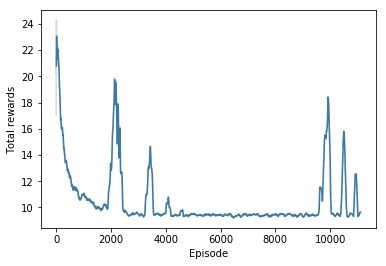

In [17]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

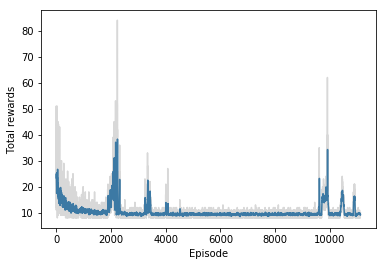

In [18]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Act losses')

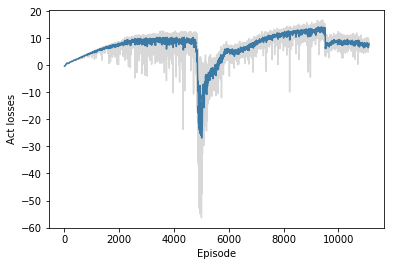

In [19]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Env losses')

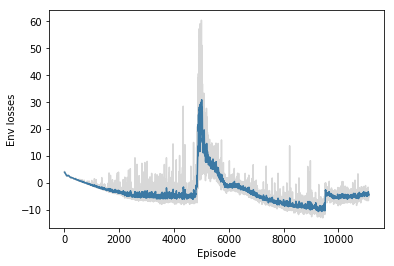

In [20]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

## Testing

Let's checkout how our trained agent plays the game.

In [21]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
